# Week 2 - Counting Words & Phrases (Computational Linguistics)
This week, we take text corpora that we have developed, spidered, scraped, and encoded, and we find and count words, simple and parsed phrases and explore the statistical properties of those counts (e.g., word frequency distributions). Initially, we model how to search corpora for keywords or phrases. Next, we examine the distributions of terms and phrases across a corpus, and the correlation between different words and phrase counts. In order to do this effectively, we coarsely disambiguate words based of part-of-speech (POS) tagging, and normalize them through stemming and lemmatization. Next we distinguish *important* words and phrase within the corpus, and image them with Wordls! Then we calculate word frequenceis, conditional frequences (the frequency of word *shock* conditional on the presence of word *awe*), and statistically significant collocations of lengths 2 through $n$. Finally, we calculate and visualize Differences (Divergences and Distances) between the word frequency distributions from two corpora.

Then we shift to focus not simply on the *ideas* in a corpus, but also extracting precise *claims*. This process involves a sequential pipeline of classifying and structuring tokens from text, each of which generates potentially useful data for the content analyst. Steps in this process, which we examine in this notebook, include: 1) tagging words by their part of speech (POS) to reveal the linguistic role they play in the sentence (e.g., Verb, Noun, Adjective, etc.); 2) tagging words as named entities (NER) such as places or organizations; 3) structuring or "parsing" sentences into nested phrases that are local to, describe or depend on one another; and 4) extracting informational claims from those phrases.

We will be introducing spaCy as a package for Computational Linguistics, and also walk you through how to use the Davies Corpora.

While we wish to avoid using NLTK for heavy corpus analysis, some of its smaller functions can still be useful.

Of course, for final projects that draw on these tools, we encourage you to install the software on your own machines or shared servers at the university (RCC, SSRC) in order to perform these operations on much more text.

For this notebook we will be using the following packages:


In [3]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
!pip install git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

import lucem_illud #just in case, regularly update your lucem_illud with the following code: pip install git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

#All these packages need to be installed from pip
import requests #for http requests
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import wordcloud #Makes word clouds
import numpy as np #For divergences/distances
import scipy #For divergences/distances
import seaborn as sns #makes our plots look nicer
import sklearn.manifold #For a manifold plot
import json #For API responses
import urllib.parse #For joining urls

# comp-linguistics
import spacy

#Displays the graphs
import graphviz #You also need to install the command line graphviz

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook
%matplotlib inline

  Cloning https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to /private/var/folders/lf/x2qjgwcx40s09kw6tkvpy7200000gn/T/pip-req-build-61p_9_3o
  Running command git clone --quiet https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git /private/var/folders/lf/x2qjgwcx40s09kw6tkvpy7200000gn/T/pip-req-build-61p_9_3o
  Resolved https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to commit 9fa6f1abdc19d159d587b4017ee6897fe7a18d4d
  Preparing metadata (setup.py) ... done


# Retrieving exemplary corpora

To get started we will need some examples. Let's start by downloading one of the corpuses from the Davies set purchased for this class and developed by a computational linguist at Brigham Young University. We can get a list of works available from the [corpora here](https://www.english-corpora.org/).

In this notebook, I will be accessing the data locally - you also have access to this data through the Dropbox download link (shared on Canvas, not here, because the GitHub is publically accessible). The same code can be modified slighlty to access the rest of the corpora on RCC. There is a notebook describing this process in the same repository, as well as in the same directory on RCC.

In [4]:
corpus_name = '/Users/apple/Desktop/SOCI40133/Zips/Movies/'

# corpus_name = "Movies"

Just to be clear, your corpus_name should be different since you're not bhargav. Modify the corpus_name with your directory. This method extracts the text from the zip files and stroes the raw data.

In [5]:
def loadcorpus(corpus_name, corpus_style="text"):
    texts_raw = {}
    for file in os.listdir(corpus_name + "/"):
        if corpus_style in file:
            print(file)
            zfile = zipfile.ZipFile(corpus_name + "/" + file)
            for file in zfile.namelist():
                texts_raw[file] = []
                with zfile.open(file) as f:
                    for line in f:
                        texts_raw[file].append(line)
    return texts_raw

In [6]:
movie_raw = loadcorpus(corpus_name)

text_13_idi.zip


text_16_qll.zip
text_32_ldf.zip
text_19_gvc.zip
text_05_nko.zip
text_17_arp.zip
text_01_ote.zip
text_28_rfy.zip
text_31_akv.zip
text_22_etp.zip
text_11_uoy.zip
text_09_oii.zip
text_06_jfy.zip
text_14_lnc.zip
text_08_loh.zip
text_33_kje.zip
text_30_wkp.zip
text_07_oma.zip
text_03_mnq.zip
text_21_fqa.zip
text_29_oye.zip
text_27_fle.zip
text_23_fmh.zip
text_12_rcq.zip
text_00_myn.zip
text_10_aoy.zip
text_04_mlq.zip
text_20_cde.zip
text_02_mqu.zip
text_26_ngj.zip
text_24_ywo.zip
text_18_jfj.zip
text_25_byg.zip
text_15_guo.zip


In [7]:
movie_raw['11.txt'][0:3]

[b'\r\n',
 b'@@216680 Hey , I \'m talking to you Give me 600 dollars You wish ! That \'s all we \'ve left And you still go to gamble Shut up I earn the money Even that you ca n\'t take it for gamble Shut up What \'re you doing ? Bastard , I \'m gon na beat you You gambling pig , I \'ll beat the shit out of you You bitch I \'ll beat you You dare to hit me with something ! I \'ll kill you All you know is gambling I \'ll beat you What \'re you doing ? Let go of me Stop You \'ll kill Mom Mom , are you all right ? Do n\'t touch my money Dad , where \'re you going ? Go away Dad , do n\'t go Get lost Dad , come back You take Marble with you The way she \'s now Do you want to give me trouble ? I \'m in more trouble than you I am a woman I \'m a sailor You take care of Marble Just gamble a bit less is enough to raise the kid No way Raising her would be like raising others @ @ @ @ @ @ @ @ @ @ take care of her Marry her when she grows up And you tell her to be smart Do n\'t marry a gambler Hey , 

It seems messy, but nothing we can't clean. This basic method replaces some of the issues with the formatting, and prints the errors if any for debugging. Let us clean one of the raw text files.

We ignore the non-unicode data for convenience in our first pass.

In [8]:
def clean_raw_text(raw_texts):
    clean_texts = []
    for text in raw_texts:
        try:
            text = text.decode("utf-8")
            clean_text = text.replace(" \'m", "'m").replace(" \'ll", "'ll").replace(" \'re", "'re").replace(" \'s", "'s").replace(" \'re", "'re").replace(" n\'t", "n't").replace(" \'ve", "'ve").replace(" /'d", "'d")
            clean_texts.append(clean_text)
        except AttributeError:
            # print("ERROR CLEANING")
            # print(text)
            continue
        except UnicodeDecodeError:
            # print("Unicode Error, Skip")
            continue
    return clean_texts

In [9]:
clean_11 = clean_raw_text(movie_raw['11.txt'])

In [10]:
clean_11[1]

'@@216680 Hey , I\'m talking to you Give me 600 dollars You wish ! That\'s all we\'ve left And you still go to gamble Shut up I earn the money Even that you can\'t take it for gamble Shut up What\'re you doing ? Bastard , I\'m gon na beat you You gambling pig , I\'ll beat the shit out of you You bitch I\'ll beat you You dare to hit me with something ! I\'ll kill you All you know is gambling I\'ll beat you What\'re you doing ? Let go of me Stop You\'ll kill Mom Mom , are you all right ? Don\'t touch my money Dad , where\'re you going ? Go away Dad , don\'t go Get lost Dad , come back You take Marble with you The way she\'s now Do you want to give me trouble ? I\'m in more trouble than you I am a woman I\'m a sailor You take care of Marble Just gamble a bit less is enough to raise the kid No way Raising her would be like raising others @ @ @ @ @ @ @ @ @ @ take care of her Marry her when she grows up And you tell her to be smart Don\'t marry a gambler Hey , you want a quarrel ? No , never

This method cleaned a few basic formatting errors. You are welcome to experiment and add your own code to expand on cleaning the text. Once it begins to look the way you want it to, we can start using spaCy to do some heavier cleaning. spaCy does this through the use of language models. Make sure you have the spaCy english language model loaded.

In [11]:
# load english language mode
nlp = spacy.load("en_core_web_sm")

This model is going to be the basis of most of the tasks which NLTK (the Natural Language Tool Kit) might have done otherwise. While NLTK uses a bunch of clunky models from multiple places, spacy neatly packs all functionality in one model. This deep trained model will start by doing our word tokenizing and normalising. These methods are already included in lucem illud, and here we will just demonstrate them outside the package so to explain what goes on under the hood.

When we run text through a spacy model, it performs a lot of computation on each of the tokens. Each token is given certain attributes, such as a part of speech, information whether it is a number, a stop word, and so on.

To perform a tokenization, we check if the string includes punctuation and add this token.

In [12]:
def word_tokenize(word_list):
    '''
    word_list:  a string'''
    tokenized = []
    # pass word list through language model.
    doc = nlp(word_list)
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

In [13]:
clean_11[1]

'@@216680 Hey , I\'m talking to you Give me 600 dollars You wish ! That\'s all we\'ve left And you still go to gamble Shut up I earn the money Even that you can\'t take it for gamble Shut up What\'re you doing ? Bastard , I\'m gon na beat you You gambling pig , I\'ll beat the shit out of you You bitch I\'ll beat you You dare to hit me with something ! I\'ll kill you All you know is gambling I\'ll beat you What\'re you doing ? Let go of me Stop You\'ll kill Mom Mom , are you all right ? Don\'t touch my money Dad , where\'re you going ? Go away Dad , don\'t go Get lost Dad , come back You take Marble with you The way she\'s now Do you want to give me trouble ? I\'m in more trouble than you I am a woman I\'m a sailor You take care of Marble Just gamble a bit less is enough to raise the kid No way Raising her would be like raising others @ @ @ @ @ @ @ @ @ @ take care of her Marry her when she grows up And you tell her to be smart Don\'t marry a gambler Hey , you want a quarrel ? No , never

In [14]:
word_tokenize('I am stupid.')

['I', 'am', 'stupid']

In [15]:
word_tokenize(clean_11[1])

['@@216680',
 'Hey',
 'I',
 "'m",
 'talking',
 'to',
 'you',
 'Give',
 'me',
 '600',
 'dollars',
 'You',
 'wish',
 'That',
 "'s",
 'all',
 'we',
 "'ve",
 'left',
 'And',
 'you',
 'still',
 'go',
 'to',
 'gamble',
 'Shut',
 'up',
 'I',
 'earn',
 'the',
 'money',
 'Even',
 'that',
 'you',
 'ca',
 "n't",
 'take',
 'it',
 'for',
 'gamble',
 'Shut',
 'up',
 'What',
 "'re",
 'you',
 'doing',
 'Bastard',
 'I',
 "'m",
 'gon',
 'na',
 'beat',
 'you',
 'You',
 'gambling',
 'pig',
 'I',
 "'ll",
 'beat',
 'the',
 'shit',
 'out',
 'of',
 'you',
 'You',
 'bitch',
 'I',
 "'ll",
 'beat',
 'you',
 'You',
 'dare',
 'to',
 'hit',
 'me',
 'with',
 'something',
 'I',
 "'ll",
 'kill',
 'you',
 'All',
 'you',
 'know',
 'is',
 'gambling',
 'I',
 "'ll",
 'beat',
 'you',
 'What',
 "'re",
 'you',
 'doing',
 'Let',
 'go',
 'of',
 'me',
 'Stop',
 'You',
 "'ll",
 'kill',
 'Mom',
 'Mom',
 'are',
 'you',
 'all',
 'right',
 'Do',
 "n't",
 'touch',
 'my',
 'money',
 'Dad',
 'where',
 "'re",
 'you',
 'going',
 'Go',
 'a

You can see how the sentence is broken into its constituent words. We can then do some analysis with this.

Note: we still don't know which movie this is, just that it is raw movie text data. Maybe in the process of our text cleaning and counting we will come across something!

# Counting words

If we want to do some analysis we can start by simply counting the number of times each word occurs within the corpus.

In [16]:
def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pandas.DataFrame(countsForFrame)

In [17]:
countedWords = wordCounter(word_tokenize(clean_11[1]))
countedWords[:10]

word  count
0  @@216680      1
1       hey     16
2         i    191
3        'm     24
4   talking      2
5        to    112
6       you    302
7      give     14
8        me     82
9       600      1

Lets sort and plot our counts to investigate the shape of our word frequency distribution.

First we need to sort the words by count.

In [18]:
#Doing this in place (changing the original DataFrame) as we don't need the unsorted DataFrame
countedWords.sort_values('count', ascending=False, inplace=True)
countedWords[:100]

word  count
6        you    302
2          i    191
13        's    126
5         to    112
31        it    109
..       ...    ...
248  postman     10
187   please      9
328      but      9
215       as      9
135      say      9

[100 rows x 2 columns]

Punctuation and very common words (articles 'a' and 'the'; prepositions 'of' and 'to') make up the most common values, but this isn't very interesting and can actually get in the way of our analysis. We may remove these 'function words' by removing according to a stopword list, setting some frequency threshold, or using a weighting scheme (like tf.idf) to decrease their influence - we will look at these methods in more detail as we go through this tutorial.

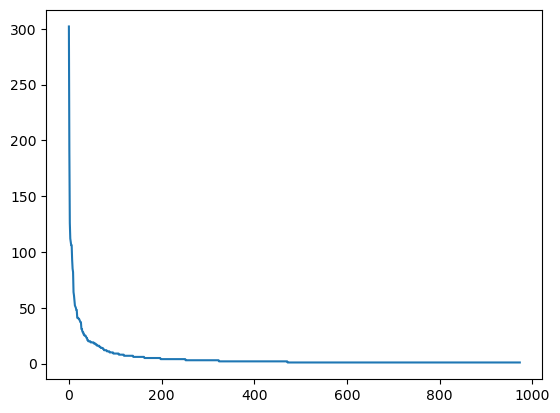

In [19]:
#Creating a figure and axis lets us do things like change the scaling or add a title
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(countedWords)), countedWords['count'])
plt.show()

This shows that likelihood of a word occurring is inversely proportional to its rank. This effect is called [Zipf's Law](https://en.wikipedia.org/wiki/Zipf%27s_law), and suggests that the most frequent word will occur approximately twice as often as the second most frequent word, three times as often as the third most frequent word, etc. Zipf's law is most easily observed by plotting the data on a log-log graph, with the axes being log (rank order) and log (frequency) resulting in a linear relationship.

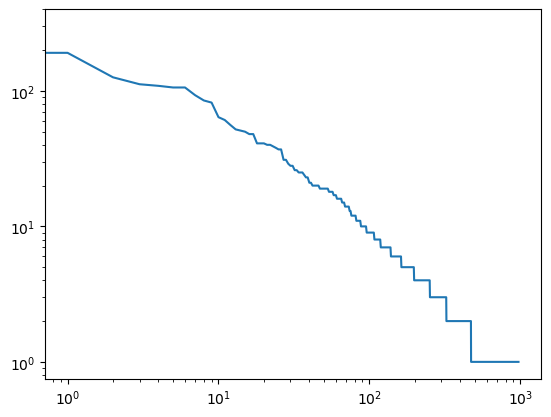

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(countedWords)), countedWords['count'])
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

(The same relationship occurs in many other rankings, such as population ranks of cities, corporation sizes, income rankings, etc.)

The distribution was imagined by Zipf to be driven by a principle of 'least effort' where speakers did not work any harder than necessary to communicate a given idea, but the basis for this relationship is still not well understood and conforms at least as well to a process of [preferential attachment](https://en.wikipedia.org/wiki/Preferential_attachment) whereby people disproportionately attend to popular words.


# Getting and working with raw text

First, we will retrieve a collection of press releases from a *GitHub API* that archived them, based on a number of analyses by Justin Grimmer, a political scientist whose work we will read in two weeks!

GitHub API requests are made to `'https://api.github.com/'` and responses are in JSON, similar to Tumblr's API.

We will get the information on [github.com/lintool/GrimmerSenatePressReleases](https://github.com/lintool/GrimmerSenatePressReleases) as it contains a nice set documents.

In [21]:
r = requests.get('https://api.github.com/repos/lintool/GrimmerSenatePressReleases')
senateReleasesData = json.loads(r.text)
print(senateReleasesData.keys())
print(senateReleasesData['description'])

dict_keys(['id', 'node_id', 'name', 'full_name', 'private', 'owner', 'html_url', 'description', 'fork', 'url', 'forks_url', 'keys_url', 'collaborators_url', 'teams_url', 'hooks_url', 'issue_events_url', 'events_url', 'assignees_url', 'branches_url', 'tags_url', 'blobs_url', 'git_tags_url', 'git_refs_url', 'trees_url', 'statuses_url', 'languages_url', 'stargazers_url', 'contributors_url', 'subscribers_url', 'subscription_url', 'commits_url', 'git_commits_url', 'comments_url', 'issue_comment_url', 'contents_url', 'compare_url', 'merges_url', 'archive_url', 'downloads_url', 'issues_url', 'pulls_url', 'milestones_url', 'notifications_url', 'labels_url', 'releases_url', 'deployments_url', 'created_at', 'updated_at', 'pushed_at', 'git_url', 'ssh_url', 'clone_url', 'svn_url', 'homepage', 'size', 'stargazers_count', 'watchers_count', 'language', 'has_issues', 'has_projects', 'has_downloads', 'has_wiki', 'has_pages', 'has_discussions', 'forks_count', 'mirror_url', 'archived', 'disabled', 'open_

What we are interested in here is the `'contents_url'`

In [22]:
print(senateReleasesData['contents_url'])

https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/{+path}


We can use this to get any or all of the files from the repo.

In [23]:
r = requests.get('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse')
whitehouseLinks = json.loads(r.text)
whitehouseLinks[0]

{'name': '10Apr2007Whitehouse123.txt',
 'path': 'raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'sha': 'f524289ee563dca58690c8d36c23dce5dbd9962a',
 'size': 2206,
 'url': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse/10Apr2007Whitehouse123.txt?ref=master',
 'html_url': 'https://github.com/lintool/GrimmerSenatePressReleases/blob/master/raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'git_url': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/git/blobs/f524289ee563dca58690c8d36c23dce5dbd9962a',
 'download_url': 'https://raw.githubusercontent.com/lintool/GrimmerSenatePressReleases/master/raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'type': 'file',
 '_links': {'self': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse/10Apr2007Whitehouse123.txt?ref=master',
  'git': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/git/blobs/f524289ee563dca58690c8d36c23dce5dbd9962a',
  'html': 'https:/

Now we have a list of information about Whitehouse press releases. Let's look at one of them.

In [24]:
r = requests.get(whitehouseLinks[0]['download_url'])
whitehouseRelease = r.text
print(whitehouseRelease[:1000])
len(whitehouseRelease)

SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY IN PUSH FOR STEM CELL RESEARCH
  Sharing the story of Lila Barber, a 12 year old girl from Westerly, Sen. Sheldon Whitehouse (D-R.I.) on Tuesday, April 10, 2007, illustrated the hope stem cell research can offer in a speech on the Senate floor in favor of legislation to expand federal funding for stem cell research.  
   Whitehouse met Lila two weeks ago. She was diagnosed two years ago with osteosarcoma, a cancerous bone condition, and last year underwent cadaver bone transplant surgery. The procedure saved her leg and is helping her remain cancer-free, but the transplanted tissue will not grow with her and likely will break down over time. Stem cell research, Whitehouse explained, could vastly improve the care of patients like Lila by allowing surgeons to enhance transplants with a patient's own stem cells, which could replace the lost bone and cartilage, or grow entirely new replacement bones and joints. 
   "Stem cell research gives hope

2206

Now we have a string of correctly encoded text. For analysis of its words, next we need to tokenize it, or split it into a sequence of tokens or word instances.

In [25]:
whTokens = word_tokenize(whitehouseRelease)
whTokens[10:30]

['STEM',
 'CELL',
 'RESEARCH',
 'Sharing',
 'the',
 'story',
 'of',
 'Lila',
 'Barber',
 'a',
 '12',
 'year',
 'old',
 'girl',
 'from',
 'Westerly',
 'Sen.',
 'Sheldon',
 'Whitehouse',
 'D']

Previous iterations of the course used `nltk`s tokenizer, but as we saw before, we used spaCy's model (https://spacy.io/api/tokenizer). We intend to avoid using NLTK when we can - for production level code, it is a lot faster and cleaner to use spaCy.

That being said, `nltk` does have some useful methods for quick analysis of small corpora. We will explore a few here, and encourage you to figure out for yourself which other ones might be useful.

To use the list of tokens in `nltk`, and take advantage of functions like `concordance`, shown above, we can convert it into a `Text`.

In [26]:
import nltk

In [27]:
whText = nltk.Text(whTokens)

whitehouseIndex = nltk.text.ConcordanceIndex(whText)
whitehouseIndex.print_concordance('Whitehouse')

Displaying 5 of 5 matches:
ld girl from Westerly Sen. Sheldon Whitehouse D R.I. on Tuesday April 10 2007 il
ral funding for stem cell research Whitehouse met Lila two weeks ago She was dia
 down over time Stem cell research Whitehouse explained could vastly improve the
s research might help or even cure Whitehouse said Whitehouse also praised the e
 help or even cure Whitehouse said Whitehouse also praised the efforts of Rhode 


*Note* that the `Text` class is for doing rapid, exploratory analysis. It provides an easy interface to many of the operations we want to do, but it does not allow us much control over the particular operations it glosses. When you are doing a more complete analysis, you should be using the module specifically designed for that task instead of the shortcut method `Text` provides, e.g. use  [`collocations` Module](http://www.nltk.org/api/nltk.html#module-nltk.collocations) instead of `.collocations()`.

Now that we have gotten this loaded, let's glance at few features we will delve into more deeply later.

For example, we can find words that statistically tend to occur together and typically have a composite, idiomatic meaning irreducible to the semantics of its component words. We will do this later with more control over exactly how these are identified.

Or we can pick a word (or words) and find what words tend to occur around it.

In [28]:
whText.common_contexts(['stem'])

for_cell on_cells the_cell hope_cell time_cell own_cells joints_cell
of_cell embryonic_cells


We can also just count the number of times the word occurs.

In [29]:
whText.count('cell')

5


We can also plot each time a set of words occurs.

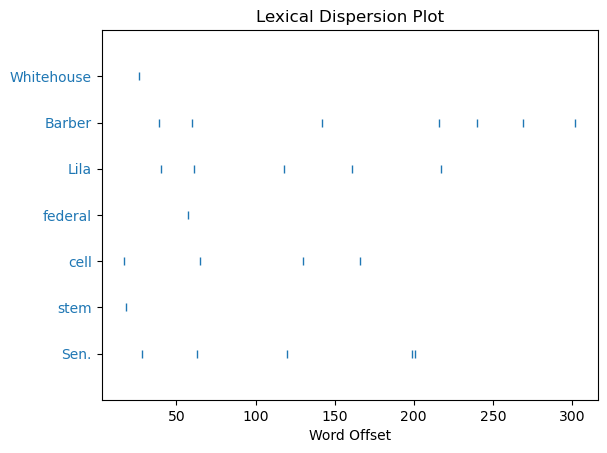

In [30]:
sns.reset_orig() #Seaborn messes with this plot, disabling it
whText.dispersion_plot(['Sen.','stem', 'cell', 'federal' ,'Lila', 'Barber', 'Whitehouse'])
plt.show()  #Add this line to display the plot
sns.set() #Re-enabling seaborn

If we want to do an analysis of all the Whitehouse press releases we will first need to obtain them. By looking at the API we can see the the URL we want is [https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse](https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse), so we can create a function to scrape the individual files.

If you want to know more about downloading from APIs, refer back to the 1st notebook.

In [31]:
def getGithubFiles(target, maxFiles = 100):
    #We are setting a max so our examples don't take too long to run
    #For converting to a DataFrame
    releasesDict = {
        'name' : [], #The name of the file
        'text' : [], #The text of the file, watch out for binary files
        'path' : [], #The path in the git repo to the file
        'html_url' : [], #The url to see the file on Github
        'download_url' : [], #The url to download the file
    }

    #Get the directory information from Github
    r = requests.get(target)
    filesLst = json.loads(r.text)

    for fileDict in filesLst[:maxFiles]:
        #These are provided by the directory
        releasesDict['name'].append(fileDict['name'])
        releasesDict['path'].append(fileDict['path'])
        releasesDict['html_url'].append(fileDict['html_url'])
        releasesDict['download_url'].append(fileDict['download_url'])

        #We need to download the text though
        text = requests.get(fileDict['download_url']).text
        releasesDict['text'].append(text)

    return pandas.DataFrame(releasesDict)

whReleases = getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse', maxFiles = 10)
whReleases[:5]

name  \
0  10Apr2007Whitehouse123.txt   
1    10Apr2008Whitehouse2.txt   
2    10Apr2008Whitehouse3.txt   
3   10Aug2007Whitehouse78.txt   
4   10Jan2008Whitehouse35.txt   

                                                text  \
0  SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY I...   
1  SEN. WHITEHOUSE SAYS PRESIDENT BUSH MUST BEGIN...   
2  EPA MUST REVIEW LEGAL PROCESS TO ROOT OUT POLI...   
3  R.I. SENATORS PRAISE SEN. DENIAL OF LNG FACILI...   
4  SEN. WHITEHOUSE COMMENTS ON ONE-YEAR ANNIVERSA...   

                                        path  \
0  raw/Whitehouse/10Apr2007Whitehouse123.txt   
1    raw/Whitehouse/10Apr2008Whitehouse2.txt   
2    raw/Whitehouse/10Apr2008Whitehouse3.txt   
3   raw/Whitehouse/10Aug2007Whitehouse78.txt   
4   raw/Whitehouse/10Jan2008Whitehouse35.txt   

                                            html_url  \
0  https://github.com/lintool/GrimmerSenatePressR...   
1  https://github.com/lintool/GrimmerSenatePressR...   
2  https://github.com/lintool/GrimmerSenatePressR...   
3  https://github.com/lintool/GrimmerSenatePressR...   
4  https://github.com/lintool/GrimmerSenatePressR...   

                                        download_url  
0  https://raw.githubusercontent.com/lintool/Grim...  
1  https://raw.githubusercontent.com/lintool/Grim...  
2  https://raw.githubusercontent.com/lintool/Grim...  
3  https://raw.githubusercontent.com/lintool/Grim...  
4  https://raw.githubusercontent.com/lintool/Grim...

If you are having trouble downloading the data uncomment this next cell

In [32]:
#whReleases = pandas.read_csv('../data/whReleases.csv')

Now we have all the texts in a DataFrame we can look at a few things.

First let's tokenize the texts with the same tokenizer as we used before. We will just save the tokens as a list for now; no need to convert to `Text`s.

In [33]:
whReleases['tokenized_text'] = whReleases['text'].apply(lambda x: word_tokenize(x))

Now lets see how long each of the press releases is:

In [34]:
whReleases['word_counts'] = whReleases['tokenized_text'].apply(lambda x: len(x))
whReleases['word_counts']

0    350
1    311
2    497
3    189
4    236
5    334
6    241
7    469
8    443
9    425
Name: word_counts, dtype: int64

## <font color="red">*Exercise 1*</font>

<font color="red">Construct cells immediately below this that input and interrogate a corpus relating to your anticipated final project. This could include one of the Davies corpora or some other you have constructed. Turn your text into an nltk `Text` object, and explore all of the features examined above, and others that relate to better understanding your corpus in relation to your research question. </font>

I am going to deal with the data retrived from "Women in Academia", a professional female community on Chinese social media on Douban.

In [35]:
# Import packages for dealing with Chinese texts
import jieba

import gensim
import re
import pandas as pd


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /Users/apple/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/apple/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/apple/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/apple/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /Users/apple/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [36]:
db_text = '由猴面包树组员倡议，我们小组建立官方slack交流群啦！为了营造一个更友好安全的交流氛围，目前加入小组slack群by invitation only，进群方式详见后文。slack目前没有地区限制，有分channel、自定义emoji、智能bot等丰富的功能，slack新手可以看这个官方slack官方指南目前设置的channel包括：#general 主channel#random 日常闲聊划水，逃避工作虽可耻但却快乐！#social-sciences 社会科学姐妹聚集地#humanities 人文艺术姐妹聚集地#engineering 工程姐妹聚集地#natural-sciences 自然科学姐妹聚集地#business 商科姐妹聚集地#prospective-phd-students 2021fall phd申请姐妹交流群#professorship 青教/AP/教职专区如果其他channel需求，可私信我开通～进群后会默认加入#general和#random，想加入其他channel可以在左边栏点击Channels旁边的加号➕，然后点击browse channels就可以看到群里所有的public channels啦然后按需加入～进群申请方式：回复本贴后立刻截图(截图里应该会包括自己刚刚的回复和本帖标题)，将截图豆油发给@猴面包树或@华丽丽的乌卒卒@个个子，同时简单阐述一下进群理由。管理员审核通过后，将会给你发送入群邀请链接～(slack群友可以邀请自己认识的不使用豆瓣的姐妹们，但需在slack上私聊 @猴面包树或@华丽丽的乌卒卒@个个子 转达被邀请者的入组理由，方可成功邀请)'
dbTokens = list(jieba.cut(db_text.strip()))

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/lf/x2qjgwcx40s09kw6tkvpy7200000gn/T/jieba.cache
Loading model cost 0.842 seconds.
Prefix dict has been built successfully.


In [37]:
dbTokens

['由',
 '猴面包树',
 '组员',
 '倡议',
 '，',
 '我们',
 '小组',
 '建立',
 '官方',
 'slack',
 '交流',
 '群',
 '啦',
 '！',
 '为了',
 '营造',
 '一个',
 '更',
 '友好',
 '安全',
 '的',
 '交流',
 '氛围',
 '，',
 '目前',
 '加入',
 '小组',
 'slack',
 '群',
 'by',
 ' ',
 'invitation',
 ' ',
 'only',
 '，',
 '进群',
 '方式',
 '详见',
 '后文',
 '。',
 'slack',
 '目前',
 '没有',
 '地区',
 '限制',
 '，',
 '有分',
 'channel',
 '、',
 '自定义',
 'emoji',
 '、',
 '智能',
 'bot',
 '等',
 '丰富',
 '的',
 '功能',
 '，',
 'slack',
 '新手',
 '可以',
 '看',
 '这个',
 '官方',
 'slack',
 '官方',
 '指南',
 '目前',
 '设置',
 '的',
 'channel',
 '包括',
 '：',
 '#',
 'general',
 ' ',
 '主',
 'channel',
 '#',
 'random',
 ' ',
 '日常',
 '闲聊',
 '划水',
 '，',
 '逃避',
 '工作',
 '虽',
 '可耻',
 '但',
 '却',
 '快乐',
 '！',
 '#',
 'social',
 '-',
 'sciences',
 ' ',
 '社会科学',
 '姐妹',
 '聚集地',
 '#',
 'humanities',
 ' ',
 '人文',
 '艺术',
 '姐妹',
 '聚集地',
 '#',
 'engineering',
 ' ',
 '工程',
 '姐妹',
 '聚集地',
 '#',
 'natural',
 '-',
 'sciences',
 ' ',
 '自然科学',
 '姐妹',
 '聚集地',
 '#',
 'business',
 ' ',
 '商科',
 '姐妹',
 '聚集地',
 '#',
 'prospective',
 '-',
 'ph

In [38]:
dbText = nltk.Text(dbTokens)
inviteIndex = nltk.text.ConcordanceIndex(dbText)
inviteIndex.print_concordance('邀请')

Displaying 3 of 3 matches:
 一下 进群 理由 。 管理员 审核 通过 后 ， 将会 给 你 发送 入群 邀请 链接 ～ ( slack 群友 可以 邀请 自己 认识 的 不 使用 豆瓣 
后 ， 将会 给 你 发送 入群 邀请 链接 ～ ( slack 群友 可以 邀请 自己 认识 的 不 使用 豆瓣 的 姐妹 们 ， 但 需 在 slack 上
 乌卒 卒 @ 个 个子   转达 被邀请者 的 入组 理由 ， 方可 成功 邀请 )


In [39]:
dbText.common_contexts(['的'])

丽_乌卒 安全_交流 丰富_功能 设置_channel 旁边_加号 所有_public 刚刚_回复 认识_不 豆瓣_姐妹 被邀请者_入组


In [40]:
dbText.count('小组')

2

In [41]:
from matplotlib.font_manager import FontProperties

chinese_font = FontProperties(fname='/Users/apple/Library/Fonts/方正姚体.TTF')

/Users/apple/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20320 (\N{CJK UNIFIED IDEOGRAPH-4F60}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/apple/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 32676 (\N{CJK UNIFIED IDEOGRAPH-7FA4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/apple/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21451 (\N{CJK UNIFIED IDEOGRAPH-53CB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/apple/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 35910 (\N{CJK UNIFIED IDEOGRAPH-8C46}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/apple/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29923 (\N{CJK UNIFIED IDEOGRAPH-74E3}) missing from c

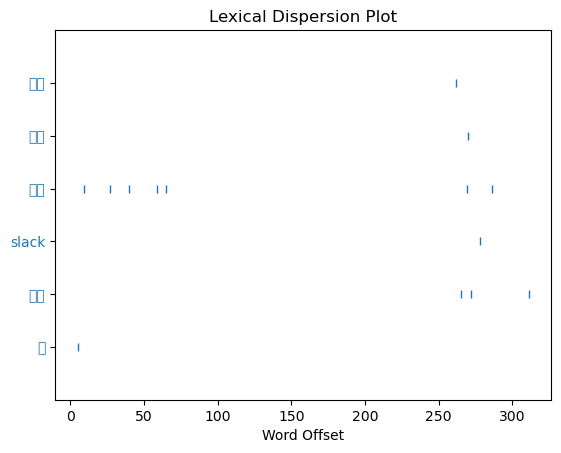

In [42]:
sns.reset_orig()  # Seaborn messes with this plot, disabling it
dbText.dispersion_plot(
    ['你', '群友', 'slack', '豆瓣', '邀请', '我们'])
plt.show()  # Add this line to display the plot
sns.set()  # Re-enabling seaborn

In [43]:
# read file
file_path = "wia.xlsx"
df = pd.read_excel(file_path)
df = df.rename(columns={'字段1': 'text', '字段2': 'like', '字段3': 'collect', '字段4': 'repost'})
df = df[df['讨论'] != '讨论']
df.head()

讨论  \
1  精华\n\n\n                    \n                ...   
2  精华\n\n\n                    \n                ...   
3  精华\n\n\n                    \n                ...   
4  精华\n\n\n                    \n                ...   
5  精华\n\n\n                    \n                ...   

                                            讨论链接       作者    回应        最后回应  \
1  https://www.douban.com/group/topic/196580000/  Anon加重音  1115  2023-12-21   
2  https://www.douban.com/group/topic/197236156/  Anon加重音    64  2023-12-01   
3  https://www.douban.com/group/topic/196808485/  Anon加重音    12  2023-07-04   
4  https://www.douban.com/group/topic/199532790/   Sophie     2  2023-05-03   
5  https://www.douban.com/group/topic/203981724/       丸子     6  2023-03-25   

                  发布时间                                               text  \
1  2020-10-09 08:25:49  由猴面包树组员倡议，我们小组建立官方slack交流群啦！为了营造一个更友好安全的交流氛围，目...   
2  2020-10-14 12:38:45  —————————本帖为问卷调查、招募研究对象的集中贴，姐妹们如有问卷调查需要大家帮忙填写或...   
3  2020-10-10 22:01:03  前情(意见征集贴) https://www.douban.com/group/topic/1...   
4  2020-11-02 04:35:37  论坛第二期分享会她说PhD：不同的人生路径的文字稿和音频分享来啦。非常感谢小组长们的全力支持...   
5  2020-12-09 03:43:55  09/30/21更新: 管理员实在是没有能力及时追踪所有申请相关的帖子，大家有相关的帖子想要...   

    like  collect  repost  
1  270.0    413.0    44.0  
2   12.0     28.0     1.0  
3   49.0     64.0     4.0  
4   13.0      6.0     NaN  
5   27.0    293.0    15.0

In [44]:
def tokenize_cn(t):
    try:
        seg_list = jieba.cut(t.strip())
    except AttributeError:
        return None

    return list(seg_list)

In [45]:
tokenize_cn("由猴面包树组员倡议，我们小组建立官方slack交流群啦！为了营造一个更友好安全的交流氛围")

['由',
 '猴面包树',
 '组员',
 '倡议',
 '，',
 '我们',
 '小组',
 '建立',
 '官方',
 'slack',
 '交流',
 '群',
 '啦',
 '！',
 '为了',
 '营造',
 '一个',
 '更',
 '友好',
 '安全',
 '的',
 '交流',
 '氛围']

In [46]:
def count_word(l):
    try:
        cnt = len(l)
    except TypeError:
        return None

    return cnt

In [47]:
# tokenize the texts
df['tokenized_text'] = df['text'].apply(lambda x: tokenize_cn(x))
df

讨论  \
1     精华\n\n\n                    \n                ...   
2     精华\n\n\n                    \n                ...   
3     精华\n\n\n                    \n                ...   
4     精华\n\n\n                    \n                ...   
5     精华\n\n\n                    \n                ...   
...                                                 ...   
5565                                 分享一个本领域senior的采访内容   
5566  精华\n\n\n                    \n                ...   
5567                                  AMA｜美国文理学院做教职（理科）   
5569  精华\n\n\n                    \n                ...   
5570                                  AMA｜美国文理学院做教职（理科）   

                                               讨论链接       作者    回应  \
1     https://www.douban.com/group/topic/196580000/  Anon加重音  1115   
2     https://www.douban.com/group/topic/197236156/  Anon加重音    64   
3     https://www.douban.com/group/topic/196808485/  Anon加重音    12   
4     https://www.douban.com/group/topic/199532790/   Sophie     2   
5     https://www.douban.com/group/topic/203981724/       丸子     6   
...                                             ...      ...   ...   
5565  https://www.douban.com/group/topic/194330533/      路亦槑     1   
5566  https://www.douban.com/group/topic/194328903/  Anon加重音   NaN   
5567  https://www.douban.com/group/topic/194271114/      多喜子     4   
5569  https://www.douban.com/group/topic/194328903/  Anon加重音   NaN   
5570  https://www.douban.com/group/topic/194271114/      多喜子     4   

            最后回应                 发布时间  \
1     2023-12-21  2020-10-09 08:25:49   
2     2023-12-01  2020-10-14 12:38:45   
3     2023-07-04  2020-10-10 22:01:03   
4     2023-05-03  2020-11-02 04:35:37   
5     2023-03-25  2020-12-09 03:43:55   
...          ...                  ...   
5565  2020-09-19  2020-09-19 11:27:25   
5566  2020-09-19  2020-09-19 11:15:22   
5567  2020-09-19  2020-09-18 20:49:48   
5569  2020-09-19  2020-09-19 11:15:22   
5570  2020-09-19  2020-09-18 20:49:48   

                                                   text   like  collect  \
1     由猴面包树组员倡议，我们小组建立官方slack交流群啦！为了营造一个更友好安全的交流氛围，目...  270.0    413.0   
2     —————————本帖为问卷调查、招募研究对象的集中贴，姐妹们如有问卷调查需要大家帮忙填写或...   12.0     28.0   
3     前情(意见征集贴) https://www.douban.com/group/topic/1...   49.0     64.0   
4     论坛第二期分享会她说PhD：不同的人生路径的文字稿和音频分享来啦。非常感谢小组长们的全力支持...   13.0      6.0   
5     09/30/21更新: 管理员实在是没有能力及时追踪所有申请相关的帖子，大家有相关的帖子想要...   27.0    293.0   
...                                                 ...    ...      ...   
5565  这位前辈人非常好，成果很多，采访内容里虽然不少是本领域specific，但是其中关于pick...    6.0      2.0   
5566  组里真是人才济济呀，为了更好地整合与利用资源，将所有AMA帖子集合在这里，方便大家交流学习P...   30.0     28.0   
5567  如题，关于美国文理学院（理科）教职申请、工作日常、工作环境、晋升要求、职业发展，欢迎提问！先...    5.0      7.0   
5569  组里真是人才济济呀，为了更好地整合与利用资源，将所有AMA帖子集合在这里，方便大家交流学习P...   30.0     28.0   
5570  如题，关于美国文理学院（理科）教职申请、工作日常、工作环境、晋升要求、职业发展，欢迎提问！先...    5.0      7.0   

      repost                                     tokenized_text  
1       44.0  [由, 猴面包树, 组员, 倡议, ，, 我们, 小组, 建立, 官方, slack, 交流...  
2        1.0  [—, —, —, —, —, —, —, —, —, 本帖, 为, 问卷调查, 、, 招募...  
3        4.0  [前, 情, (, 意见, 征集, 贴, ),  , https, :, /, /, www...  
4        NaN  [论坛, 第二期, 分享, 会, 她, 说, PhD, ：, 不同, 的, 人生, 路径, ...  
5       15.0  [09, /, 30, /, 21, 更新, :,  , 管理员, 实在, 是, 没有, 能...  
...      ...                                                ...  
5565     2.0  [这位, 前辈, 人, 非常, 好, ，, 成果, 很多, ，, 采访, 内容, 里, 虽然...  
5566     2.0  [组, 里, 真是, 人才济济, 呀, ，, 为了, 更好, 地, 整合, 与, 利用, 资...  
5567     1.0  [如, 题, ，, 关于, 美国, 文理学院, （, 理科, ）, 教职, 申请, 、, 工...  
5569     2.0  [组, 里, 真是, 人才济济, 呀, ，, 为了, 更好, 地, 整合, 与, 利用, 资...  
5570     1.0  [如, 题, ，, 关于, 美国, 文理学院, （, 理科, ）, 教职, 申请, 、, 工...  

[5386 rows x 11 columns]

In [48]:
df['word_counts'] = df['tokenized_text'].apply(lambda x: count_word(x))
df['word_counts']

1       313.0
2        67.0
3       244.0
4       177.0
5       478.0
        ...  
5565     69.0
5566     72.0
5567     79.0
5569     72.0
5570     79.0
Name: word_counts, Length: 5386, dtype: float64

# Filtering and normalizing text

As we want to start comparing the different releases we may choose to do a bit of filtering and normalizing that will allow us to focus on what we most care about. We can first make all of the words lower case, then drop the non-word tokens. Next, we can remove some 'stop words', stem the remaining words to remove suffixes, prefixes and (in some languages) infixes, or lemmatize tokens by intelligently grouping inflected or variant forms of the same word (e.g., with a stemmer and a dictionary).

To begin this process, we will first define a function to work over the tokenized lists, then another to add normalized tokens to a new column.

We will be using spaCy's built in stop words identifying capacity. When we run text through spaCy's language pipeline, it automatically tags it as a stop word.

We can remove these stopwords from the analysis by fiat, but we could also take a more principled approach by looking at the frequency distribution of words and selecting a specific cut-off associated with the preservation of 'meaningful words' identified upon inspection. Alternatively, we could automatically set a cut-off by rule, such as removal of all words more frequent then the most frequent verb, or the most frequent noun (not pronoun), or some term of central interest.

In [49]:
countsDict = {}
for word in whReleases['tokenized_text'].sum():
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)
word_counts[:20]

[('the', 179),
 ('of', 112),
 ('to', 112),
 ('and', 108),
 ('in', 64),
 ('a', 61),
 ("'s", 50),
 ('that', 41),
 ('our', 39),
 ('for', 35),
 ('on', 33),
 ('is', 33),
 ('Whitehouse', 31),
 ('Iraq', 28),
 ('Bush', 27),
 ('President', 25),
 ('troops', 21),
 ('by', 19),
 ('American', 19),
 ('with', 18)]

We can look at this and pick the cutoff, often at the first noun. So we will cut all words before `'Whitehouse'`.

In [50]:
#The stop list is then all words that occur before the first noun
stop_words_freq = []
for word, count in word_counts:
    if word == 'Whitehouse':
        break
    else:
        stop_words_freq.append(word)
stop_words_freq

['the', 'of', 'to', 'and', 'in', 'a', "'s", 'that', 'our', 'for', 'on', 'is']

If we did have any extra words to add as stop words apart from those normally considered as stop words, we would add it to our stop words by passing it to the normalize tokens method.

Now we can create our function to normalize the tokens

In [51]:
def normalizeTokens(word_list, extra_stop=[]):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list])

    doc = nlp(word_list.lower())

    # add the property of stop word to words considered as stop words
    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
            normalized.append(str(w.lemma_))

    return normalized

In [52]:
whReleases['normalized_tokens'] = whReleases['tokenized_text'].apply(lambda x: normalizeTokens(x))

whReleases['normalized_tokens_count'] = whReleases['normalized_tokens'].apply(lambda x: len(x))

whReleases

name  \
0  10Apr2007Whitehouse123.txt   
1    10Apr2008Whitehouse2.txt   
2    10Apr2008Whitehouse3.txt   
3   10Aug2007Whitehouse78.txt   
4   10Jan2008Whitehouse35.txt   
5    10Mar2008Whitehouse8.txt   
6   10Sep2007Whitehouse72.txt   
7  11Apr2007Whitehouse122.txt   
8  11Jan2007Whitehouse161.txt   
9    11Mar2008Whitehouse7.txt   

                                                text  \
0  SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY I...   
1  SEN. WHITEHOUSE SAYS PRESIDENT BUSH MUST BEGIN...   
2  EPA MUST REVIEW LEGAL PROCESS TO ROOT OUT POLI...   
3  R.I. SENATORS PRAISE SEN. DENIAL OF LNG FACILI...   
4  SEN. WHITEHOUSE COMMENTS ON ONE-YEAR ANNIVERSA...   
5  SENS. REED, WHITEHOUSE WELCOME RHODE ISLAND ST...   
6  REP. WHITEHOUSE ISSUES STATEMENT ON GEN. PETRA...   
7  SEN. WHITEHOUSE URGES BUSH FOR NEW DIRECTION I...   
8  SENS. REED, WHITEHOUSE URGE PORTUGAL TO RECONS...   
9  WHITEHOUSE UNVEILS 'BUSH DEBT': $7.7 TRILLION ...   

                                        path  \
0  raw/Whitehouse/10Apr2007Whitehouse123.txt   
1    raw/Whitehouse/10Apr2008Whitehouse2.txt   
2    raw/Whitehouse/10Apr2008Whitehouse3.txt   
3   raw/Whitehouse/10Aug2007Whitehouse78.txt   
4   raw/Whitehouse/10Jan2008Whitehouse35.txt   
5    raw/Whitehouse/10Mar2008Whitehouse8.txt   
6   raw/Whitehouse/10Sep2007Whitehouse72.txt   
7  raw/Whitehouse/11Apr2007Whitehouse122.txt   
8  raw/Whitehouse/11Jan2007Whitehouse161.txt   
9    raw/Whitehouse/11Mar2008Whitehouse7.txt   

                                            html_url  \
0  https://github.com/lintool/GrimmerSenatePressR...   
1  https://github.com/lintool/GrimmerSenatePressR...   
2  https://github.com/lintool/GrimmerSenatePressR...   
3  https://github.com/lintool/GrimmerSenatePressR...   
4  https://github.com/lintool/GrimmerSenatePressR...   
5  https://github.com/lintool/GrimmerSenatePressR...   
6  https://github.com/lintool/GrimmerSenatePressR...   
7  https://github.com/lintool/GrimmerSenatePressR...   
8  https://github.com/lintool/GrimmerSenatePressR...   
9  https://github.com/lintool/GrimmerSenatePressR...   

                                        download_url  \
0  https://raw.githubusercontent.com/lintool/Grim...   
1  https://raw.githubusercontent.com/lintool/Grim...   
2  https://raw.githubusercontent.com/lintool/Grim...   
3  https://raw.githubusercontent.com/lintool/Grim...   
4  https://raw.githubusercontent.com/lintool/Grim...   
5  https://raw.githubusercontent.com/lintool/Grim...   
6  https://raw.githubusercontent.com/lintool/Grim...   
7  https://raw.githubusercontent.com/lintool/Grim...   
8  https://raw.githubusercontent.com/lintool/Grim...   
9  https://raw.githubusercontent.com/lintool/Grim...   

                                      tokenized_text  word_counts  \
0  [SEN, WHITEHOUSE, SHARES, WESTERLY, GIRL, 'S, ...          350   
1  [SEN, WHITEHOUSE, SAYS, PRESIDENT, BUSH, MUST,...          311   
2  [EPA, MUST, REVIEW, LEGAL, PROCESS, TO, ROOT, ...          497   
3  [R.I., SENATORS, PRAISE, SEN, DENIAL, OF, LNG,...          189   
4  [SEN, WHITEHOUSE, COMMENTS, ON, ONE, YEAR, ANN...          236   
5  [SENS, REED, WHITEHOUSE, WELCOME, RHODE, ISLAN...          334   
6  [REP, WHITEHOUSE, ISSUES, STATEMENT, ON, GEN, ...          241   
7  [SEN, WHITEHOUSE, URGES, BUSH, FOR, NEW, DIREC...          469   
8  [SENS, REED, WHITEHOUSE, URGE, PORTUGAL, TO, R...          443   
9  [WHITEHOUSE, UNVEILS, BUSH, DEBT, $, 7.7, TRIL...          425   

                                   normalized_tokens  normalized_tokens_count  
0  [sen, whitehouse, share, westerly, girl, story...                      224  
1  [sen, whitehouse, say, president, bush, begin,...                      159  
2  [epa, review, legal, process, root, political,...                      298  
3  [r.i, senator, praise, sen, denial, lng, facil...                      116  
4  [sen, whitehouse, comment, year, anniversary, ...                      125  
5  [sen, reed, whitehouse, welcome, rhode

You can see that in the final step of normalizing, we add the lemmatized form of the word. spaCy's built in lemmatizer does this (https://spacy.io/api/lemmatizer). Lemmatization can be thought of as finding the root or the base of the word after removing inflections and other variations of words. Another possible way of finding the roots of words is using NLTK's porting or stemming functionalities, but we will not be getting into them.

Now that it is cleaned we start analyzing the dataset. We can start by finding frequency distributions for the dataset. Lets start looking at all the press releases together. The [`ConditionalFreqDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ConditionalProbDist) class reads in an iterable of tuples, the first element is the condition and the second the focal word. For starters, we will use word lengths as the conditions, but tags or clusters will provide more useful results.

In [53]:
#.sum() adds together the lists from each row into a single list
whcfdist = nltk.ConditionalFreqDist(((len(w), w) for w in whReleases['normalized_tokens'].sum()))

#print the number of words
print(whcfdist.N())

1964


From this we can lookup the distributions of different word lengths

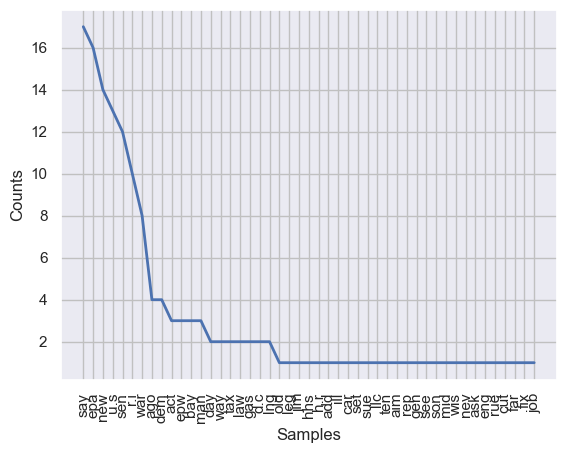

<Axes: xlabel='Samples', ylabel='Counts'>

In [54]:
whcfdist[3].plot()

We can also create a Conditional Probability Distribution or [`ConditionalProbDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ConditionalProbDist) from the `ConditionalFreqDist`. To do this, however, we need a model for the probability distribution. A simple model is [`ELEProbDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ELEProbDist) which gives the expected likelihood estimate for the probability distribution of the experiment used to generate the observed frequency distribution.

In [55]:
whcpdist = nltk.ConditionalProbDist(whcfdist, nltk.ELEProbDist)

#print the most common 2 letter word
print(whcpdist[2].max())

#And its probability
print(whcpdist[2].prob(whcpdist[2].max()))

ri
0.25


Length is one feature of a word, but there are many more important features we care about. Another critical feature is a word's role in the sentence, or its part of speech (POS).

The method below works similarly to ```nltk.pos_text```, and can work with the conditional frequency distributions it provides.

In [56]:
def spacy_pos(word_list):
    tags = []
    doc = nlp(word_list.lower())
    for w in doc:
        tags.append((w.text, w.tag_))
    return tags

In [57]:
whReleases['normalized_tokens_POS'] = [spacy_pos(t) for t in whReleases['text']]

In [58]:
whReleases['normalized_tokens_POS'].head()

0    [(sen, NNP), (., NNP), (whitehouse, NNP), (sha...
1    [(sen, NNP), (., NNP), (whitehouse, NNP), (say...
2    [(epa, NNP), (must, MD), (review, VB), (legal,...
3    [(r.i, NNP), (., NNP), (senators, NNS), (prais...
4    [(sen, NNP), (., NNP), (whitehouse, NNP), (com...
Name: normalized_tokens_POS, dtype: object

This gives us a new column with the part of speech as a short initialism and the word in a tuple, exactly how the `nltk.ConditionalFreqDist()` function wants them. We can now construct another conditional frequency distribution.

In [59]:
whcfdist_WordtoPOS = nltk.ConditionalFreqDist(whReleases['normalized_tokens_POS'].sum())
list(whcfdist_WordtoPOS.items())[:10]

[('sen', FreqDist({'NNP': 9})),
 ('.', FreqDist({'.': 126, 'NNP': 39, 'NN': 1})),
 ('whitehouse', FreqDist({'NN': 21, 'NNP': 19})),
 ('shares', FreqDist({'NNS': 1})),
 ('westerly', FreqDist({'RB': 2})),
 ('girl', FreqDist({'NN': 2})),
 ("'s", FreqDist({'POS': 47, 'VBZ': 5})),
 ('story', FreqDist({'NN': 2})),
 ('in', FreqDist({'IN': 72})),
 ('push', FreqDist({'NN': 1}))]

This gives the frequency of each word as each part of speech...which can be uninformative and boring. What we want is the converse; the frequency of each part of speech for each word.

In [60]:
whcfdist_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in whReleases['normalized_tokens_POS'].sum())

We can now identify and collect all of the superlative adjectives

In [61]:
whcfdist_POStoWord['JJ']

FreqDist({'american': 17, 'new': 11, 'portuguese': 9, 'political': 8, 'federal': 6, 'clear': 5, 'general': 5, 'potential': 5, 'fiscal': 5, 'last': 4, ...})

Or look at the most common nouns

In [62]:
whcfdist_POStoWord['NN'].most_common(5)

[('whitehouse', 21),
 ('rhode', 19),
 ('island', 15),
 ('today', 15),
 ('stem', 12)]

Or plot the base form verbs against their number of occurrences

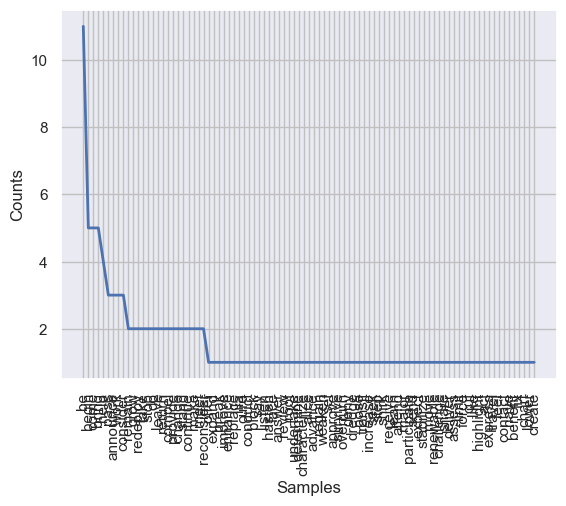

<Axes: xlabel='Samples', ylabel='Counts'>

In [63]:
whcfdist_POStoWord['VB'].plot()

We can then do a similar analysis of the word probabilities

In [64]:
whcpdist_POStoWord = nltk.ConditionalProbDist(whcfdist_POStoWord, nltk.ELEProbDist)

#print the most common nouns
print(whcpdist_POStoWord['NN'].max())

#And its probability
print(whcpdist_POStoWord['NN'].prob(whcpdist_POStoWord['NN'].max()))

whitehouse
0.025190392501464556


We can even create a...wait for it...*WORD CLOUD* or Wordl to gaze at and draw mystical, approximate inferences about important nouns and verbs in our corpus:

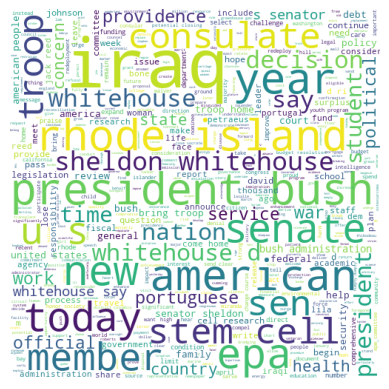

In [65]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(whReleases['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.show()
plt.savefig("whitehouse_word_cloud.pdf", format = 'pdf')

## <font color="red">*Exercise 2*</font>

<font color="red">Construct cells immediately below this that filter, stem and lemmatize the tokens in your corpus, and then creates plots (with titles and labels) that map the word frequency distribution, word probability distribution, and at least two conditional probability distributions that help us better understand the social and cultural game underlying the production of your corpus. Create a wordl of words (or normalized words) and add a few vague comments about what mysteries are revealed through it.</font>

In [66]:
all_words = [word for sublist in df['tokenized_text']
             if sublist is not None for word in sublist]

counts_dict = {}
for word in all_words:
    counts_dict[word] = counts_dict.get(word, 0) + 1

word_counts = sorted(counts_dict.items(), key = lambda x : x[1], reverse = True)
word_counts[20:]

[('就', 4924),
 ('想', 4828),
 ('可以', 4747),
 ('一个', 4698),
 ('！', 4658),
 ('申请', 4647),
 ('：', 4543),
 ('做', 4460),
 ('—', 4306),
 ('没有', 4176),
 ('大家', 4163),
 ('会', 3969),
 ('、', 3812),
 ('但', 3707),
 ('这个', 3659),
 ('但是', 3643),
 ('研究', 3613),
 ('老师', 3402),
 ('导师', 3317),
 ('说', 3211),
 ('对', 3141),
 ('好', 3122),
 ('学校', 3060),
 ('去', 3019),
 ('如果', 3000),
 ('要', 2931),
 ('所以', 2930),
 ('因为', 2895),
 ('你', 2832),
 ('现在', 2798),
 ('问题', 2768),
 ('…', 2714),
 ('什么', 2637),
 ('方向', 2636),
 ('给', 2579),
 ('写', 2553),
 ('能', 2535),
 ('知道', 2533),
 ('还', 2514),
 ('还是', 2459),
 ('专业', 2459),
 ('到', 2453),
 ('人', 2435),
 ('一些', 2433),
 ('比较', 2375),
 ('一下', 2374),
 ('工作', 2354),
 ('可能', 2322),
 ('这', 2251),
 ('上', 2247),
 ('觉得', 2233),
 ('姐妹', 2146),
 ('项目', 2074),
 ('他', 2048),
 ('目前', 2039),
 ('们', 2001),
 ('感觉', 1977),
 ('就是', 1945),
 ('论文', 1939),
 ('博士', 1934),
 ('吗', 1930),
 (',', 1930),
 ('时候', 1919),
 ('多', 1913),
 ('看', 1886),
 ('需要', 1876),
 ('学术', 1869),
 ('\n', 1833),
 ('-', 180

In [67]:
# The stop list is then all words that occur before the first noun
stop_words_freq = []
for word, count in word_counts:
    if word == '申请':
        break
    else:
        stop_words_freq.append(word)
stop_words_freq

['，',
 '的',
 ' ',
 '。',
 '我',
 '了',
 '是',
 '在',
 '有',
 '也',
 '和',
 '（',
 '）',
 '不',
 '自己',
 '都',
 '？',
 '很',
 '/',
 '.',
 '就',
 '想',
 '可以',
 '一个',
 '！']

In [68]:
# load Chinese stopwords
def stopwordslist(path):
    stopwords = [line.strip()
                 for line in open(path, encoding='UTF-8').readlines()]
    return stopwords
stoplist = stopwordslist(r'/Users/apple/Desktop/SOCI40133/Week2/my_stopwords.txt')  # 这里请输入停用词的路径

In [69]:
stoplist[:10]

['里', '是', '有', '想', '很', '出', '做', '不', '日', '月']

In [70]:
def normalize_cn_Tokens(word_list, extra_stop=[]):
    # We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list])

    if word_list == None:
        return None
    
    doc = nlp(word_list)

    # add the property of stop word to words considered as stop words
    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0 and w.text not in stoplist:
            # we add the lematized version of the word
            normalized.append(str(w.lemma_))

    return normalized

In [71]:
normalize_cn_Tokens(df['tokenized_text'][2])

['本帖',
 '问卷调查',
 '招募',
 '研究',
 '对象',
 '贴',
 '姐妹',
 '问卷调查',
 '帮忙',
 '填写',
 '招募',
 '研究',
 '对象',
 '私信',
 '告知',
 '管理员',
 '本楼',
 '回复',
 '详细信息',
 '单独',
 '发帖',
 '一律',
 '删除',
 '组员',
 '热心',
 '填写',
 '需注意',
 '甄别',
 '保护',
 '隐私',
 '信息']

In [72]:
def cal_length(word_list):
    if word_list == None:
        return None
    return len(word_list)

In [73]:
df['normalized_tokens'] = df['tokenized_text'].apply(lambda x: normalize_cn_Tokens(x))

df

讨论  \
1     精华\n\n\n                    \n                ...   
2     精华\n\n\n                    \n                ...   
3     精华\n\n\n                    \n                ...   
4     精华\n\n\n                    \n                ...   
5     精华\n\n\n                    \n                ...   
...                                                 ...   
5565                                 分享一个本领域senior的采访内容   
5566  精华\n\n\n                    \n                ...   
5567                                  AMA｜美国文理学院做教职（理科）   
5569  精华\n\n\n                    \n                ...   
5570                                  AMA｜美国文理学院做教职（理科）   

                                               讨论链接       作者    回应  \
1     https://www.douban.com/group/topic/196580000/  Anon加重音  1115   
2     https://www.douban.com/group/topic/197236156/  Anon加重音    64   
3     https://www.douban.com/group/topic/196808485/  Anon加重音    12   
4     https://www.douban.com/group/topic/199532790/   Sophie     2   
5     https://www.douban.com/group/topic/203981724/       丸子     6   
...                                             ...      ...   ...   
5565  https://www.douban.com/group/topic/194330533/      路亦槑     1   
5566  https://www.douban.com/group/topic/194328903/  Anon加重音   NaN   
5567  https://www.douban.com/group/topic/194271114/      多喜子     4   
5569  https://www.douban.com/group/topic/194328903/  Anon加重音   NaN   
5570  https://www.douban.com/group/topic/194271114/      多喜子     4   

            最后回应                 发布时间  \
1     2023-12-21  2020-10-09 08:25:49   
2     2023-12-01  2020-10-14 12:38:45   
3     2023-07-04  2020-10-10 22:01:03   
4     2023-05-03  2020-11-02 04:35:37   
5     2023-03-25  2020-12-09 03:43:55   
...          ...                  ...   
5565  2020-09-19  2020-09-19 11:27:25   
5566  2020-09-19  2020-09-19 11:15:22   
5567  2020-09-19  2020-09-18 20:49:48   
5569  2020-09-19  2020-09-19 11:15:22   
5570  2020-09-19  2020-09-18 20:49:48   

                                                   text   like  collect  \
1     由猴面包树组员倡议，我们小组建立官方slack交流群啦！为了营造一个更友好安全的交流氛围，目...  270.0    413.0   
2     —————————本帖为问卷调查、招募研究对象的集中贴，姐妹们如有问卷调查需要大家帮忙填写或...   12.0     28.0   
3     前情(意见征集贴) https://www.douban.com/group/topic/1...   49.0     64.0   
4     论坛第二期分享会她说PhD：不同的人生路径的文字稿和音频分享来啦。非常感谢小组长们的全力支持...   13.0      6.0   
5     09/30/21更新: 管理员实在是没有能力及时追踪所有申请相关的帖子，大家有相关的帖子想要...   27.0    293.0   
...                                                 ...    ...      ...   
5565  这位前辈人非常好，成果很多，采访内容里虽然不少是本领域specific，但是其中关于pick...    6.0      2.0   
5566  组里真是人才济济呀，为了更好地整合与利用资源，将所有AMA帖子集合在这里，方便大家交流学习P...   30.0     28.0   
5567  如题，关于美国文理学院（理科）教职申请、工作日常、工作环境、晋升要求、职业发展，欢迎提问！先...    5.0      7.0   
5569  组里真是人才济济呀，为了更好地整合与利用资源，将所有AMA帖子集合在这里，方便大家交流学习P...   30.0     28.0   
5570  如题，关于美国文理学院（理科）教职申请、工作日常、工作环境、晋升要求、职业发展，欢迎提问！先...    5.0      7.0   

      repost                                     tokenized_text  word_counts  \
1       44.0  [由, 猴面包树, 组员, 倡议, ，, 我们, 小组, 建立, 官方, slack, 交流...        313.0   
2        1.0  [—, —, —, —, —, —, —, —, —, 本帖, 为, 问卷调查, 、, 招募...         67.0   
3        4.0  [前, 情, (, 意见, 征集, 贴, ),  , https, :, /, /, www...        244.0   
4        NaN  [论坛, 第二期, 分享, 会, 她, 说, PhD, ：, 不同, 的, 人生, 路径, ...        177.0   
5       15.0  [09, /, 30, /, 21, 更新, :,  , 管理员, 实在, 是, 没有, 能...        478.0   
...      ...                                                ...          ...   
5565     2.0  [这位, 前辈, 人, 非常, 好, ，, 成果, 很多, ，, 采访, 内容, 里, 虽然...         69.0   
5566     2.0  [组, 里, 真是, 人才济济, 呀, ，, 为了, 更好, 地, 整合, 与, 利用, 资...         72.0   
5567     1.0  [如, 题, ，, 关于, 美国, 文理学院, （, 理科, ）, 教职, 申请, 、, 工...         79.0   
5569     2.0  [组, 里, 真是, 人才济济, 呀, ，, 为了, 更好, 地, 整合, 与, 利用, 资...         72.0   
5570     1.0  [如, 题, ，, 关于, 美国, 文理学院, （, 理科, ）, 教职, 申请, 、, 工...         79.0   

                                      normalized_tokens  
1     [猴面包树, 组员, 倡议, 小组, 建立, 官方, slack, 交流, 群, 营造, 更...  
2     [本帖, 问卷调查, 招募, 研究, 对象, 贴, 

In [74]:
df['normalized_tokens_count'] = df['normalized_tokens'].apply(
    lambda x: cal_length(x))

df

讨论  \
1     精华\n\n\n                    \n                ...   
2     精华\n\n\n                    \n                ...   
3     精华\n\n\n                    \n                ...   
4     精华\n\n\n                    \n                ...   
5     精华\n\n\n                    \n                ...   
...                                                 ...   
5565                                 分享一个本领域senior的采访内容   
5566  精华\n\n\n                    \n                ...   
5567                                  AMA｜美国文理学院做教职（理科）   
5569  精华\n\n\n                    \n                ...   
5570                                  AMA｜美国文理学院做教职（理科）   

                                               讨论链接       作者    回应  \
1     https://www.douban.com/group/topic/196580000/  Anon加重音  1115   
2     https://www.douban.com/group/topic/197236156/  Anon加重音    64   
3     https://www.douban.com/group/topic/196808485/  Anon加重音    12   
4     https://www.douban.com/group/topic/199532790/   Sophie     2   
5     https://www.douban.com/group/topic/203981724/       丸子     6   
...                                             ...      ...   ...   
5565  https://www.douban.com/group/topic/194330533/      路亦槑     1   
5566  https://www.douban.com/group/topic/194328903/  Anon加重音   NaN   
5567  https://www.douban.com/group/topic/194271114/      多喜子     4   
5569  https://www.douban.com/group/topic/194328903/  Anon加重音   NaN   
5570  https://www.douban.com/group/topic/194271114/      多喜子     4   

            最后回应                 发布时间  \
1     2023-12-21  2020-10-09 08:25:49   
2     2023-12-01  2020-10-14 12:38:45   
3     2023-07-04  2020-10-10 22:01:03   
4     2023-05-03  2020-11-02 04:35:37   
5     2023-03-25  2020-12-09 03:43:55   
...          ...                  ...   
5565  2020-09-19  2020-09-19 11:27:25   
5566  2020-09-19  2020-09-19 11:15:22   
5567  2020-09-19  2020-09-18 20:49:48   
5569  2020-09-19  2020-09-19 11:15:22   
5570  2020-09-19  2020-09-18 20:49:48   

                                                   text   like  collect  \
1     由猴面包树组员倡议，我们小组建立官方slack交流群啦！为了营造一个更友好安全的交流氛围，目...  270.0    413.0   
2     —————————本帖为问卷调查、招募研究对象的集中贴，姐妹们如有问卷调查需要大家帮忙填写或...   12.0     28.0   
3     前情(意见征集贴) https://www.douban.com/group/topic/1...   49.0     64.0   
4     论坛第二期分享会她说PhD：不同的人生路径的文字稿和音频分享来啦。非常感谢小组长们的全力支持...   13.0      6.0   
5     09/30/21更新: 管理员实在是没有能力及时追踪所有申请相关的帖子，大家有相关的帖子想要...   27.0    293.0   
...                                                 ...    ...      ...   
5565  这位前辈人非常好，成果很多，采访内容里虽然不少是本领域specific，但是其中关于pick...    6.0      2.0   
5566  组里真是人才济济呀，为了更好地整合与利用资源，将所有AMA帖子集合在这里，方便大家交流学习P...   30.0     28.0   
5567  如题，关于美国文理学院（理科）教职申请、工作日常、工作环境、晋升要求、职业发展，欢迎提问！先...    5.0      7.0   
5569  组里真是人才济济呀，为了更好地整合与利用资源，将所有AMA帖子集合在这里，方便大家交流学习P...   30.0     28.0   
5570  如题，关于美国文理学院（理科）教职申请、工作日常、工作环境、晋升要求、职业发展，欢迎提问！先...    5.0      7.0   

      repost                                     tokenized_text  word_counts  \
1       44.0  [由, 猴面包树, 组员, 倡议, ，, 我们, 小组, 建立, 官方, slack, 交流...        313.0   
2        1.0  [—, —, —, —, —, —, —, —, —, 本帖, 为, 问卷调查, 、, 招募...         67.0   
3        4.0  [前, 情, (, 意见, 征集, 贴, ),  , https, :, /, /, www...        244.0   
4        NaN  [论坛, 第二期, 分享, 会, 她, 说, PhD, ：, 不同, 的, 人生, 路径, ...        177.0   
5       15.0  [09, /, 30, /, 21, 更新, :,  , 管理员, 实在, 是, 没有, 能...        478.0   
...      ...                                                ...          ...   
5565     2.0  [这位, 前辈, 人, 非常, 好, ，, 成果, 很多, ，, 采访, 内容, 里, 虽然...         69.0   
5566     2.0  [组, 里, 真是, 人才济济, 呀, ，, 为了, 更好, 地, 整合, 与, 利用, 资...         72.0   
5567     1.0  [如, 题, ，, 关于, 美国, 文理学院, （, 理科, ）, 教职, 申请, 、, 工...         79.0   
5569     2.0  [组, 里, 真是, 人才济济, 呀, ，, 为了, 更好, 地, 整合, 与, 利用, 资...         72.0   
5570     1.0  [如, 题, ，, 关于, 美国, 文理学院, （, 理科, ）, 教职, 申请, 、, 工...         79.0   

                                      normalized_tokens  \
1     [猴面包树, 组员, 倡议, 小组, 建立, 官方, slack, 交流, 群, 营造, 更...   
2     [本帖, 问卷调查, 招募, 研究, 对象, 贴

In [75]:
# Concatenate all lists in the 'normalized_tokens' column into a single list
all_tokens = [token for sublist in df['normalized_tokens']
              if isinstance(sublist, list) for token in sublist]

# Create a ConditionalFreqDist using all_tokens
dfcfdist = nltk.ConditionalFreqDist((len(w), w) for w in all_tokens)

# Print the number of words
print(dfcfdist.N())

498047


/Users/apple/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27605 (\N{CJK UNIFIED IDEOGRAPH-6BD5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/apple/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 19994 (\N{CJK UNIFIED IDEOGRAPH-4E1A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/apple/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 35770 (\N{CJK UNIFIED IDEOGRAPH-8BBA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/apple/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25991 (\N{CJK UNIFIED IDEOGRAPH-6587}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/apple/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38750 (\N{CJK UNIFIED IDEOGRAPH-975E}) missing from c

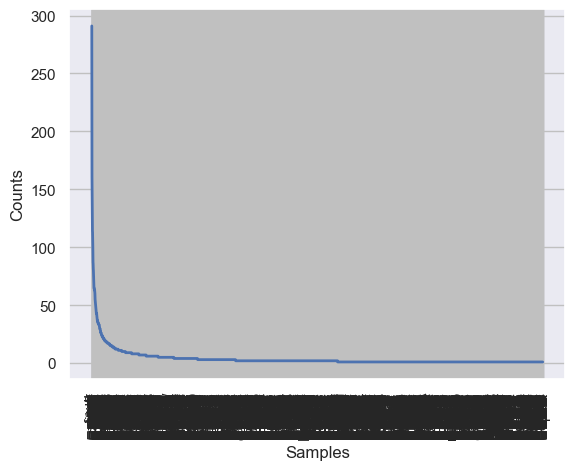

<Axes: xlabel='Samples', ylabel='Counts'>

In [76]:
dfcfdist[4].plot()

In [77]:
dfcpdist = nltk.ConditionalProbDist(dfcfdist, nltk.ELEProbDist)

# print the most common 2 letter word
print(dfcpdist[2].max())

# And its probability
print(dfcpdist[2].prob(dfcpdist[2].max()))

print("")
print(dfcpdist[3].max())
print(dfcpdist[3].prob(dfcpdist[2].max()))

print("")
print(dfcpdist[4].max())
print(dfcpdist[4].prob(dfcpdist[2].max()))

申请
0.013706912442396314

phd
1.157340431687981e-05

毕业论文
2.308136180034622e-05


In [78]:
# identify a Chinese word's role in the sentence
import jieba.posseg as pseg

In [79]:
text = df["text"][1]

# 使用jieba库进行中文分词和词性标注
words = pseg.cut(text)

# 输出词语和对应的词性
for word, pos in words:
    print(word, pos)

由 p
猴面包树 n
组员 n
倡议 n
， x
我们 r
小组 n
建立 v
官方 n
slack eng
交流 n
群 q
啦 y
！ x
为了 p
营造 vn
一个 m
更 d
友好 a
安全 an
的 uj
交流 n
氛围 n
， x
目前 t
加入 v
小组 n
slack eng
群 n
by eng
  x
invitation eng
  x
only eng
， x
进群 v
方式 n
详见 a
后 f
文 n
。 x
slack eng
目前 t
没有 v
地区 n
限制 v
， x
有 v
分 q
channel eng
、 x
自定义 l
emoji eng
、 x
智能 n
bot eng
等 u
丰富 a
的 uj
功能 n
， x
slack eng
新手 n
可以 c
看 v
这个 r
官方 n
slack eng
官方 n
指南 n
目前 t
设置 vn
的 uj
channel eng
包括 v
： x
# x
general eng
  x
主 b
channel eng
# x
random eng
  x
日常 d
闲聊 v
划水 v
， x
逃避 v
工作 vn
虽 zg
可耻 a
但 c
却 d
快乐 a
！ x
# x
social eng
- x
sciences eng
  x
社会科学 nt
姐妹 n
聚集地 n
# x
humanities eng
  x
人文 n
艺术 n
姐妹 n
聚集地 n
# x
engineering eng
  x
工程 n
姐妹 n
聚集地 n
# x
natural eng
- x
sciences eng
  x
自然科学 l
姐妹 n
聚集地 n
# x
business eng
  x
商科 n
姐妹 n
聚集地 n
# x
prospective eng
- x
phd eng
- x
students eng
  x
2021 m
fall eng
  x
phd eng
申请 v
姐妹 n
交流 n
群 n
# x
professorship eng
  x
青教 nz
/ x
AP eng
/ x
教职 n
专区 n
如果 c
其他 r
channel eng
需求 v
， x
可 v
私信 n
我 r
开通 v
～ x
进群 n
后 f
会 v
默认 v
加入 

In [80]:
def cn_pos(word_list):
    tags = []
    
    try:
        words = pseg.cut(word_list)
        for word, pos in words:
            tags.append((word, pos))
    except AttributeError:
        return None
    
    return tags

In [81]:
cn_pos(df["text"][1])

[('由', 'p'),
 ('猴面包树', 'n'),
 ('组员', 'n'),
 ('倡议', 'n'),
 ('，', 'x'),
 ('我们', 'r'),
 ('小组', 'n'),
 ('建立', 'v'),
 ('官方', 'n'),
 ('slack', 'eng'),
 ('交流', 'n'),
 ('群', 'q'),
 ('啦', 'y'),
 ('！', 'x'),
 ('为了', 'p'),
 ('营造', 'vn'),
 ('一个', 'm'),
 ('更', 'd'),
 ('友好', 'a'),
 ('安全', 'an'),
 ('的', 'uj'),
 ('交流', 'n'),
 ('氛围', 'n'),
 ('，', 'x'),
 ('目前', 't'),
 ('加入', 'v'),
 ('小组', 'n'),
 ('slack', 'eng'),
 ('群', 'n'),
 ('by', 'eng'),
 (' ', 'x'),
 ('invitation', 'eng'),
 (' ', 'x'),
 ('only', 'eng'),
 ('，', 'x'),
 ('进群', 'v'),
 ('方式', 'n'),
 ('详见', 'a'),
 ('后', 'f'),
 ('文', 'n'),
 ('。', 'x'),
 ('slack', 'eng'),
 ('目前', 't'),
 ('没有', 'v'),
 ('地区', 'n'),
 ('限制', 'v'),
 ('，', 'x'),
 ('有', 'v'),
 ('分', 'q'),
 ('channel', 'eng'),
 ('、', 'x'),
 ('自定义', 'l'),
 ('emoji', 'eng'),
 ('、', 'x'),
 ('智能', 'n'),
 ('bot', 'eng'),
 ('等', 'u'),
 ('丰富', 'a'),
 ('的', 'uj'),
 ('功能', 'n'),
 ('，', 'x'),
 ('slack', 'eng'),
 ('新手', 'n'),
 ('可以', 'c'),
 ('看', 'v'),
 ('这个', 'r'),
 ('官方', 'n'),
 ('slack', 'eng'),
 ('官方', '

In [82]:
df['normalized_tokens_POS'] = df['text'].apply(lambda x: cn_pos(x))
df['normalized_tokens_POS'].head()

1    [(由, p), (猴面包树, n), (组员, n), (倡议, n), (，, x), ...
2    [(—, x), (—, x), (—, x), (—, x), (—, x), (—, x...
3    [(前, f), (情, n), ((, x), (意见, n), (征集, v), (贴,...
4    [(论坛, n), (第二期, m), (分享, v), (会, v), (她, r), (...
5    [(09, m), (/, x), (30, m), (/, x), (21, m), (更...
Name: normalized_tokens_POS, dtype: object

In [83]:
# Concatenate all lists in the 'normalized_tokens' column into a single list
all_pos = [pos for sublist in df['normalized_tokens']
              if isinstance(sublist, list) for pos in sublist]

# Create a ConditionalFreqDist using all_tokens
dfcfdist = nltk.ConditionalFreqDist((len(w), w) for w in all_pos)

# Print the number of words
print(dfcfdist.N())

498047


In [84]:
# Assuming 'normalized_tokens' contains lists of words
all_words = [word for sublist in df['normalized_tokens']
             if isinstance(sublist, list) for word in sublist]

# Generate POS tags for all words
all_word_pos_pairs = nltk.pos_tag(all_words)

# Create the ConditionalFreqDist
dfcfdist_WordtoPOS = nltk.ConditionalFreqDist(all_word_pos_pairs)

# Viewing the first 10 items
list(dfcfdist_WordtoPOS.items())[:10]

[('猴面包树', FreqDist({'NNP': 3, 'JJ': 1})),
 ('组员', FreqDist({'NNP': 50, 'VBD': 1})),
 ('倡议', FreqDist({'NNP': 2})),
 ('小组', FreqDist({'NNP': 333, 'JJ': 1})),
 ('建立', FreqDist({'NNP': 114})),
 ('官方', FreqDist({'NNP': 40})),
 ('slack', FreqDist({'NN': 26})),
 ('交流', FreqDist({'NNP': 577, 'NN': 4, 'VBD': 1})),
 ('群', FreqDist({'NNP': 123})),
 ('营造', FreqDist({'NNP': 6}))]

In [85]:
dfcfdist_POStoWord = nltk.ConditionalFreqDist(
    (p, w) for w, p in all_word_pos_pairs)

In [86]:
dfcfdist_POStoWord['NNP']

FreqDist({'申请': 4592, '会': 3951, '研究': 3601, '老师': 3384, '导师': 3299, '说': 3195, '好': 3105, '学校': 3045, '去': 3008, '方向': 2620, ...})

In [87]:
dfcfdist_POStoWord['NN'].most_common(5)

[('phd', 1703),
 ('offer', 847),
 ('research', 725),
 ('paper', 427),
 ('https', 393)]

/Users/apple/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12562 (\N{BOPOMOFO LETTER X}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/apple/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38754 (\N{CJK UNIFIED IDEOGRAPH-9762}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/apple/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 35797 (\N{CJK UNIFIED IDEOGRAPH-8BD5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/apple/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 35828 (\N{CJK UNIFIED IDEOGRAPH-8BF4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/apple/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20316 (\N{CJK UNIFIED IDEOGRAPH-4F5C}) missing from current fo

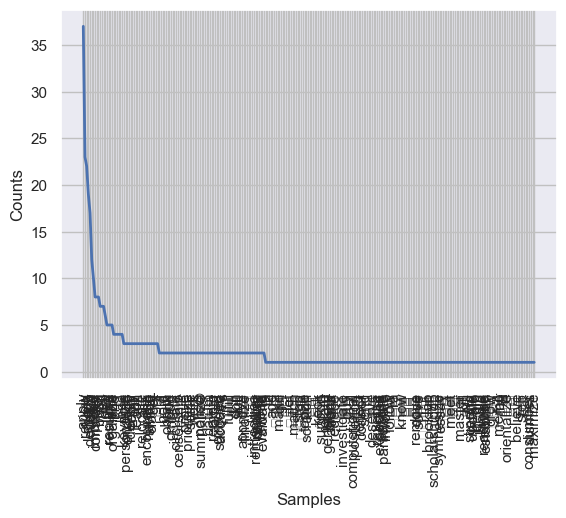

<Axes: xlabel='Samples', ylabel='Counts'>

In [88]:
dfcfdist_POStoWord['VB'].plot()

In [89]:
# word probabilities
dfcpdist_POStoWord = nltk.ConditionalProbDist(
    dfcfdist_POStoWord, nltk.ELEProbDist)

# print the most common nouns
print(dfcpdist_POStoWord['NNP'].max())

# And its probability
print(dfcpdist_POStoWord['NNP'].prob(dfcpdist_POStoWord['NN'].max()))

申请
1.0577566884599803e-06


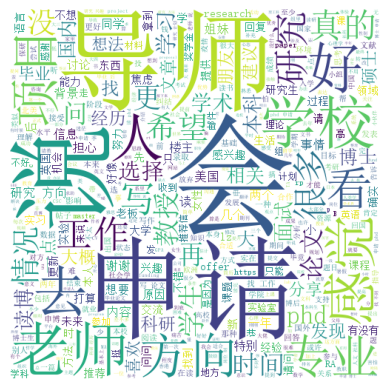

In [90]:
font_path = '/Users/apple/Library/Group Containers/UBF8T346G9.Office/FontCache/4/CloudFonts/NSimSun/46250601858.ttf'

wc = wordcloud.WordCloud(font_path=font_path, background_color="white", max_words=500, width=1000, height=1000,
                         mode='RGBA', scale=.5).generate(' '.join(all_words))
plt.imshow(wc)
plt.axis("off")
plt.show()
plt.savefig("whitehouse_word_cloud.pdf", format='pdf')

## Davies Corpora

Now that we have our basic cleaning down, we can arrange our Davies Corpora. Let us try this with the movies corpora we have already loaded.

We'll use a smaller corpus of a 1000 movies for this demonstration.

In [91]:
zfile = zipfile.ZipFile(corpus_name + "/sources_movies.zip")
source = []

In [92]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [93]:
source[0:20]

[b'textID\tfileID\t#words\tgenre\tyear\tlanguage(s)\tcountry\timdb\ttitle\r\n',
 b'-----\t-----\t-----\t-----\t-----\t-----\t-----\t-----\t-----\r\n',
 b'\r\n',
 b'290635\t3547424\t4722\tShort, Musical\t1930\tUK\tEnglish\t0290635\tGoodbye to All That\r\n',
 b'21165\t6332374\t10220\tCrime, Mystery, Thriller\t1930\tUK\tEnglish\t0021165\tMurder!\r\n',
 b'21191\t6013789\t5281\tDrama, Romance\t1930\tUSA\tEnglish\t0021191\tA Notorious Affair\r\n',
 b'20620\t3660608\t6724\tBiography, Drama, History\t1930\tUSA\tEnglish\t0020620\tAbraham Lincoln\r\n',
 b'20629\t60053\t9552\tDrama, War\t1930\tUSA\tEnglish, French, German, Latin\t0020629\tAll Quiet on the Western Front\r\n',
 b'20640\t6850720\t13862\tComedy, Musical\t1930\tUSA\tEnglish\t0020640\tAnimal Crackers\r\n',
 b'20641\t176501\t11140\tDrama, Romance\t1930\tUSA\tEnglish\t0020641\tAnna Christie\r\n',
 b'20643\t3603861\t1748\tComedy, Short\t1930\tUSA\tEnglish\t0020643\tAnother Fine Mess\r\n',
 b'20670\t4159455\t6966\tComedy, Musical\t1930\tUS

It looks dirty because the file is encoded as bytes, but we can certainly see the information there. The file id is also present in the original raw text data: as the first "word". Look back at the normalized/tokenized words to confirm that. We're going to use this to create a dataframe with: Fileid, movie name, genre, year, and country.

It is advised that you run a similar check of the source file before you do other extraction.

First, let us create a dictionary mapping file-id to all the text. Each movie will be mapped to a list of the tokenized words.

In this example, I only use it to load 100 movies. You can comment this out or increase/decrease the number as you see fit.

Note that in the following cells, we make use of the `lucem_illud` package's `word_tokenize` function. You can see that function on line 70 of [processing.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/processing.py), and we provide the code here for transparency. Since we put this folder in our helper package, you won't need to define this function every time you want to use it; you just `import lucem_illud`!

In [94]:
# processing.py calls a spacy model called "en" (and sometimes called "en_core_web_sm") so we load that first.
try:
    nlp = spacy.load("en")
except OSError:
    nlp = spacy.load("en_core_web_sm")


#Here is the function from lucem_illud/lucem_illud/processing.py
def word_tokenize(word_list, model=nlp, MAX_LEN=1500000):

    tokenized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list])
    # since we're only tokenizing, I remove RAM intensive operations and increase max text size

    model.max_length = MAX_LEN
    doc = model(word_list, disable=["parser", "tagger", "ner"])

    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

In [95]:
movie_texts = {}

In [96]:
for files in movie_raw:
    if len(movie_texts) > 100:
        break
    movies = clean_raw_text(movie_raw[files][1:])
    for movie in movies:
        # We can run the following line of code with or without `lucem_illud.`, using the package or our code 2 cells above.
        txts = lucem_illud.word_tokenize(movie)
        try:
            movie_texts[txts[0][2:]] = txts[1:]
        except IndexError:
            continue

In [97]:
import pandas as pd

In [98]:
movie_df = pd.DataFrame(columns=["Movie Name", "Genre", "Year", "Country", "Tokenized Texts"])

In [99]:
for movie in source[3:]:
    try:
        tid, fileid, total_words, genre, year, lang, country, imdb, title = movie.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    try:
        movie_df.loc[fileid.strip()] = [title.strip(), genre.strip(), year.strip(), country.strip(), movie_texts[fileid.strip()]]
    except KeyError:
        continue

In [100]:
movie_df.head()

Movie Name            Genre  Year          Country  \
6850720    Animal Crackers  Comedy, Musical  1930          English   
176501       Anna Christie   Drama, Romance  1930          English   
4056770  Ladies of Leisure   Drama, Romance  1930          English   
5992934      Over the Hill            Drama  1931          English   
4436137  Design for Living  Comedy, Romance  1933  English, French   

                                           Tokenized Texts  
6850720  [You, must, do, your, best, tonight, Be, on, y...  
176501   [Either, you, 're, flat, or, I, am, I, beg, yo...  
4056770  [Look, out, There, 's, another, bottle, coming...  
5992934  [Good, morning, kitty, Come, in, here, baby, I...  
4436137  [Train_engine_grinding, 26;1426;TOOLONG, Whist...

# Part-of-Speech (POS) tagging

In POS tagging, we classify each word by its semantic role in a sentence. We will be using the in-built spaCy pos-tagging.

https://spacy.io/usage/linguistic-features

|#. |Tag |Description |
|---|----|------------|
|1.	|CC	|Coordinating conjunction
|2.	|CD	|Cardinal number
|3.	|DT	|Determiner
|4.	|EX	|Existential there
|5.	|FW	|Foreign word
|6.	|IN	|Preposition or subordinating conjunction
|7.	|JJ	|Adjective
|8.	|JJR|	Adjective, comparative
|9.	|JJS|	Adjective, superlative
|10.|	LS	|List item marker
|11.|	MD	|Modal
|12.|	NN	|Noun, singular or mass
|13.|	NNS	|Noun, plural
|14.|	NNP	|Proper noun, singular
|15.|	NNPS|	Proper noun, plural
|16.|	PDT	|Predeterminer
|17.|	POS	|Possessive ending
|18.|	PRP	|Personal pronoun
|19.|	PRP\$|	Possessive pronoun
|20.|	RB	|Adverb
|21.|	RBR	|Adverb, comparative
|22.|	RBS	|Adverb, superlative
|23.|	RP	|Particle
|24.|	SYM	|Symbol
|25.|	TO	|to
|26.|	UH	|Interjection
|27.|	VB	|Verb, base form
|28.|	VBD	|Verb, past tense
|29.|	VBG	|Verb, gerund or present participle
|30.|	VBN	|Verb, past participle
|31.|	VBP	|Verb, non-3rd person singular present
|32.|	VBZ	|Verb, 3rd person singular present
|33.|	WDT	|Wh-determiner
|34.|	WP	|Wh-pronoun
|35.|	WP$	|Possessive wh-pronoun
|36.|	WRB	|Wh-adverb

spaCy pos-tags word as we run it through the english language model. A small example:

In [101]:
sent = nlp(u"Tom went to IKEA to get some of those delicious Swedish meatballs.")


In [102]:
for token in sent:
    print(token.text, token.pos_, token.tag_)

Tom PROPN NNP
went VERB VBD
to ADP IN
IKEA NOUN NN
to PART TO
get VERB VB
some PRON DT
of ADP IN
those DET DT
delicious ADJ JJ
Swedish ADJ JJ
meatballs NOUN NNS
. PUNCT .


This looks quite good. Now we will try POS tagging with a somewhat larger corpus. We consider a few of the top posts from the reddit data we used last week.

In [103]:
redditDF = pandas.read_csv('/Users/apple/Desktop/SOCI40133/data/reddit.csv')

In [104]:
redditDF.head()

Unnamed: 0             author  over_18  score                subreddit  \
0           0   guitarsdontdance    False  14089  Tales From Tech Support   
1           1             SECGaz    False  13724  Tales From Tech Support   
2           2  Clickity_clickity    False  13404  Tales From Tech Support   
3           3     TheDroolinFool    False  13152  Tales From Tech Support   
4           4        goldie-gold    False  12650  Tales From Tech Support   

                                                text  \
0  So my story starts on what was a normal day ta...   
1  > $Me  - Hello, IT.   > $Usr - Hi, I am still ...   
2  [Part 1](http://www.reddit.com/r/talesfromtech...   
3  Another tale from the out of hours IT desk... ...   
4  This just happened...  So, I had a laptop syst...   

                                               title  \
0  "Don't bother sending a tech, I'll be dead by ...   
1              Hi, I am still off sick but I am not.   
2                   Jack, the Worst End User, Part 4   
3       "I need you to fix Google Bing immediately!"   
4      Engineer is doing drugs!! No. No they aren't.   

                                                 url  
0  https://www.reddit.com/r/talesfromtechsupport/...  
1  https://www.reddit.com/r/talesfromtechsupport/...  
2  https://www.reddit.com/r/talesfromtechsupport/...  
3  https://www.reddit.com/r/talesfromtechsupport/...  
4  https://www.reddit.com/r/talesfromtechsupport/...

Grabbing the 10 highest scoring posts and tokenizing the sentences. Once again, notice that we aren't going to do any kind of stemming this week (although *semantic* normalization may be performed where we translate synonyms into the same focal word). Here, we will use sentences tokenized by spaCy. Like before, these methods can also be found in `lucem_illud`.



In [105]:
def sent_tokenize(word_list):
    doc = nlp(word_list)
    sentences = [sent.text.strip() for sent in doc.sents]
    return sentences

In [106]:
redditTopScores = redditDF.sort_values('score')[-10:]
redditTopScores['sentences'] = redditTopScores['text'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])
redditTopScores.index = range(len(redditTopScores) - 1, -1,-1) #Reindex to make things nice in the future
redditTopScores

/Users/apple/anaconda3/lib/python3.11/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Unnamed: 0                author  over_18  score                subreddit  \
9           8        brenkelieshere    False   9448  Tales From Tech Support   
8           7             Bombadils    False  10528  Tales From Tech Support   
7        1200  whenlifegivesyoushit    False  11003            Relationships   
6           6                sfsdfd    False  11295  Tales From Tech Support   
5           5               Raitaro    False  12372  Tales From Tech Support   
4           4           goldie-gold    False  12650  Tales From Tech Support   
3           3        TheDroolinFool    False  13152  Tales From Tech Support   
2           2     Clickity_clickity    False  13404  Tales From Tech Support   
1           1                SECGaz    False  13724  Tales From Tech Support   
0           0      guitarsdontdance    False  14089  Tales From Tech Support   

                                                text  \
9  Last year, Help Desk got a call from a user co...   
8  First post in quite some time! I work at a loc...   
7  [Original Post](https://www.reddit.com/r/relat...   
6  I witnessed this astounding IT meltdown around...   
5  I work Helpdesk for a retail store chain in th...   
4  This just happened...  So, I had a laptop syst...   
3  Another tale from the out of hours IT desk... ...   
2  [Part 1](http://www.reddit.com/r/talesfromtech...   
1  > $Me  - Hello, IT.   > $Usr - Hi, I am still ...   
0  So my story starts on what was a normal day ta...   

                                               title  \
9  How to fix a laptop that won't boot in under a...   
8                  OK, now the password is 'D35p41r'   
7  [UPDATE]My [26 F] with my husband [29 M] 1 yea...   
6  Company-wide email + 30,000 employees + auto-r...   
5  I'm pretty sure I knocked a user out from near...   
4      Engineer is doing drugs!! No. No they aren't.   
3       "I need you to fix Google Bing immediately!"   
2                   Jack, the Worst End User, Part 4   
1              Hi, I am still off sick but I am not.   
0  "Don't bother sending a tech, I'll be dead by ...   

                                                 url  \
9  https://www.reddit.com/r/talesfromtechsupport/...   
8  https://www.reddit.com/r/talesfromtechsupport/...   
7  https://www.reddit.com/r/relationships/comment...   
6  https://www.reddit.com/r/talesfromtechsupport/...   
5  https://www.reddit.com/r/talesfromtechsupport/...   
4  https://www.reddit.com/r/talesfromtechsupport/...   
3  https://www.reddit.com/r/talesfromtechsupport/...   
2  https://www.reddit.com/r/talesfromtechsupport/...   
1  https://www.reddit.com/r/talesfromtechsupport/...   
0  https://www.reddit.com/r/talesfromtechsupport/...   

                                           sentences  
9  [[Last, year, Help, Desk, got, a, call, from, ...  
8  [[First, post, in, quite, some, time], [I, wor...  
7  [[Original, Post](https://www.reddit.com, r, r...  
6  [[I, witnessed, this, astounding, IT, meltdown...  
5  [[I, work, Helpdesk, for, a, retail, store, ch...  
4  [[This, just, happened], [So, I, had, a, lapto...  
3  [[Another, tale, from, the, out, of, hours, IT...  
2  [[Part, 1](http://www.reddit.com, r, talesfrom...  
1  [[>, $, Me, Hello, IT], [>, $, Usr, Hi, I, am,...  
0  [[So, my, story, starts, on, what, was, a, nor...

In [107]:
def tag_sents_pos(sentences):
    """
    function which replicates NLTK pos tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)

    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for token in sent:
            pos_sent.append((token.text, token.tag_))
        pos_sents.append(pos_sent)

    return pos_sents

In [108]:
redditTopScores['POS_sents'] = redditTopScores['sentences'].apply(lambda x: tag_sents_pos(x))

In [109]:
redditTopScores['POS_sents']

9    [[(Last, JJ), (year, NN), (Help, NNP), (Desk, ...
8    [[(First, JJ), (post, NN), (in, IN), (quite, P...
7    [[(Original, JJ), (Post](https://www.reddit.co...
6    [[(I, PRP), (witnessed, VBD), (this, DT), (ast...
5    [[(I, PRP), (work, VBP), (Helpdesk, NNP), (for...
4    [[(This, DT), (just, RB), (happened, VBD), (So...
3    [[(Another, DT), (tale, NN), (from, IN), (the,...
2    [[(Part, NN), (1](http://www.reddit.com, NNP),...
1    [[(>, XX), ($, $), (Me, PRP)], [(Hello, UH), (...
0    [[(So, RB), (my, PRP$), (story, NN), (starts, ...
Name: POS_sents, dtype: object

And count the number of `NN` (nouns)

In [110]:
countTarget = 'NN'
targetCounts = {}
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('password', 22),
 ('time', 14),
 ('computer', 13),
 ('lot', 12),
 ('life', 11),
 ('email', 11),
 ('system', 10),
 ('laptop', 9),
 ('message', 9),
 ('day', 9),
 ('auto', 9),
 ('call', 8),
 ('office', 8),
 ('part', 8),
 ('today', 8),
 ('story', 8),
 ('job', 7),
 ('something', 7),
 ('problem', 7),
 ('drawer', 7)]

What about the adjectives that modify the word, "computer"?

In [111]:
NTarget = 'JJ'
Word = 'computer'
NResults = set()
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)

{'unrestricted', 'own'}


## <font color="red">Exercise 3</font>

<font color="red">In the cells immediately following, perform POS tagging on a meaningful (but modest) subset of a corpus associated with your final project. Examine the list of words associated with at least three different parts of speech. Consider conditional associations (e.g., adjectives associated with nouns or adverbs with verbs of interest). What do these distributions suggest about your corpus?

In [112]:
df.head()

讨论  \
1  精华\n\n\n                    \n                ...   
2  精华\n\n\n                    \n                ...   
3  精华\n\n\n                    \n                ...   
4  精华\n\n\n                    \n                ...   
5  精华\n\n\n                    \n                ...   

                                            讨论链接       作者    回应        最后回应  \
1  https://www.douban.com/group/topic/196580000/  Anon加重音  1115  2023-12-21   
2  https://www.douban.com/group/topic/197236156/  Anon加重音    64  2023-12-01   
3  https://www.douban.com/group/topic/196808485/  Anon加重音    12  2023-07-04   
4  https://www.douban.com/group/topic/199532790/   Sophie     2  2023-05-03   
5  https://www.douban.com/group/topic/203981724/       丸子     6  2023-03-25   

                  发布时间                                               text  \
1  2020-10-09 08:25:49  由猴面包树组员倡议，我们小组建立官方slack交流群啦！为了营造一个更友好安全的交流氛围，目...   
2  2020-10-14 12:38:45  —————————本帖为问卷调查、招募研究对象的集中贴，姐妹们如有问卷调查需要大家帮忙填写或...   
3  2020-10-10 22:01:03  前情(意见征集贴) https://www.douban.com/group/topic/1...   
4  2020-11-02 04:35:37  论坛第二期分享会她说PhD：不同的人生路径的文字稿和音频分享来啦。非常感谢小组长们的全力支持...   
5  2020-12-09 03:43:55  09/30/21更新: 管理员实在是没有能力及时追踪所有申请相关的帖子，大家有相关的帖子想要...   

    like  collect  repost                                     tokenized_text  \
1  270.0    413.0    44.0  [由, 猴面包树, 组员, 倡议, ，, 我们, 小组, 建立, 官方, slack, 交流...   
2   12.0     28.0     1.0  [—, —, —, —, —, —, —, —, —, 本帖, 为, 问卷调查, 、, 招募...   
3   49.0     64.0     4.0  [前, 情, (, 意见, 征集, 贴, ),  , https, :, /, /, www...   
4   13.0      6.0     NaN  [论坛, 第二期, 分享, 会, 她, 说, PhD, ：, 不同, 的, 人生, 路径, ...   
5   27.0    293.0    15.0  [09, /, 30, /, 21, 更新, :,  , 管理员, 实在, 是, 没有, 能...   

   word_counts                                  normalized_tokens  \
1        313.0  [猴面包树, 组员, 倡议, 小组, 建立, 官方, slack, 交流, 群, 营造, 更...   
2         67.0  [本帖, 问卷调查, 招募, 研究, 对象, 贴, 姐妹, 问卷调查, 帮忙, 填写, 招募...   
3        244.0  [前, 情, 意见, 征集, 贴, https, www, douban, group, t...   
4        177.0  [论坛, 第二期, 分享, 会, 说, phd, 人生, 路径, 文字, 稿, 音频, 分享...   
5        478.0  [更新, 管理员, 实在, 能力, 追踪, 申请, 相关, 帖子, 相关, 帖子, 想要, ...   

   normalized_tokens_count                              normalized_tokens_POS  
1                    173.0  [(由, p), (猴面包树, n), (组员, n), (倡议, n), (，, x), ...  
2                     31.0  [(—, x), (—, x), (—, x), (—, x), (—, x), (—, x...  
3                    127.0  [(前, f), (情, n), ((, x), (意见, n), (征集, v), (贴,...  
4                     73.0  [(论坛, n), (第二期, m), (分享, v), (会, v), (她, r), (...  
5                    227.0  [(09, m), (/, x), (30, m), (/, x), (21, m), (更...

In [113]:
import re

In [114]:
sent_list = re.split('(?:[。！!?.？])?([^。！!?.？]+)(?:[。！!?.？])', df['text'][1])
sent_list

['',
 '由猴面包树组员倡议，我们小组建立官方slack交流群啦',
 '',
 '为了营造一个更友好安全的交流氛围，目前加入小组slack群by invitation only，进群方式详见后文',
 '',
 'slack目前没有地区限制，有分channel、自定义emoji、智能bot等丰富的功能，slack新手可以看这个官方slack官方指南目前设置的channel包括：#general 主channel#random 日常闲聊划水，逃避工作虽可耻但却快乐',
 '',
 '#social-sciences 社会科学姐妹聚集地#humanities 人文艺术姐妹聚集地#engineering 工程姐妹聚集地#natural-sciences 自然科学姐妹聚集地#business 商科姐妹聚集地#prospective-phd-students 2021fall phd申请姐妹交流群#professorship 青教/AP/教职专区如果其他channel需求，可私信我开通～进群后会默认加入#general和#random，想加入其他channel可以在左边栏点击Channels旁边的加号➕，然后点击browse channels就可以看到群里所有的public channels啦然后按需加入～进群申请方式：回复本贴后立刻截图(截图里应该会包括自己刚刚的回复和本帖标题)，将截图豆油发给@猴面包树或@华丽丽的乌卒卒@个个子，同时简单阐述一下进群理由',
 '管理员审核通过后，将会给你发送入群邀请链接～(slack群友可以邀请自己认识的不使用豆瓣的姐妹们，但需在slack上私聊 @猴面包树或@华丽丽的乌卒卒@个个子 转达被邀请者的入组理由，方可成功邀请)']

In [115]:
normalize_cn_Tokens(df['tokenized_text'][1])

['猴面包树',
 '组员',
 '倡议',
 '小组',
 '建立',
 '官方',
 'slack',
 '交流',
 '群',
 '营造',
 '更',
 '友好',
 '交流',
 '氛围',
 '小组',
 'slack',
 '群',
 'invitation',
 '进群',
 '方式',
 '详见',
 '后文',
 'slack',
 '地区',
 '有分',
 'channel',
 '自定义',
 'emoji',
 '智能',
 'bot',
 '功能',
 'slack',
 '新手',
 '看',
 '官方',
 'slack',
 '官方',
 '指南',
 '设置',
 'channel',
 '包括',
 'general',
 '主',
 'channel',
 'random',
 '日常',
 '闲聊',
 '划水',
 '逃避',
 '工作',
 '可耻',
 '快乐',
 'social',
 'science',
 '社会科学',
 '姐妹',
 '聚集地',
 'humanitie',
 '人文',
 '艺术',
 '姐妹',
 '聚集地',
 'engineering',
 '工程',
 '姐妹',
 '聚集地',
 'natural',
 'science',
 '自然科学',
 '姐妹',
 '聚集地',
 'business',
 '商科',
 '姐妹',
 '聚集地',
 'prospective',
 'phd',
 'student',
 '2021fall',
 'phd',
 '申请',
 '姐妹',
 '交流',
 '群',
 'professorship',
 '青教',
 'AP',
 '教职',
 '专区',
 'channel',
 '需求',
 '私信',
 '开通',
 '～',
 '进群',
 '后会',
 '默认',
 'general',
 'random',
 'channel',
 '左边',
 '栏',
 '点击',
 'channel',
 '旁边',
 '加号',
 '➕',
 '点击',
 'browse',
 'channel',
 '群里',
 'public',
 'channel',
 '需',
 '～',
 '进群',
 '申请',
 '方式',
 '回复',

In [116]:
def sent_cn_tokenize(word_list):
    if word_list == None:
        return None
    
    sent = []
    sentences = []
    for word in word_list:
        if word != '。' and word != '！' and word != '!' and word != '?' and word != '.' and word != '？':
            sent.append(word)
        else:
            sentences.append(normalize_cn_Tokens(sent))
            sent = []

    return sentences

In [117]:
sent_cn_tokenize(df['tokenized_text'][5])

[['更新',
  '管理员',
  '实在',
  '能力',
  '追踪',
  '申请',
  '相关',
  '帖子',
  '相关',
  '帖子',
  '想要',
  '推荐',
  '加进',
  '楼里',
  '楼里',
  '回复',
  '私信',
  '～',
  '申请',
  '姐妹',
  '更',
  '快',
  '找到',
  '组中',
  '已有',
  '帖子',
  '小组',
  '申请',
  '相关',
  '帖子',
  '反复',
  '刷屏',
  '管理员',
  '建立',
  '楼'],
 ['学科', '主题', '分类', '楼', '链接', '套磁', '相关', 'https', 'www'],
 ['douban'],
 ['group', 'topic', '推荐信', '相关', 'https', 'www'],
 ['douban'],
 ['group', 'topic', '人文', '社科', '综合', '申请', '相关', 'https', 'www'],
 ['douban'],
 ['group', 'topic', 'STEM', '综合', '申请', '相关', 'https', 'www'],
 ['douban'],
 ['group', 'topic', '艺术类', '综合', '申请', '相关', 'https', 'www'],
 ['douban'],
 ['group',
  'topic',
  '提问',
  '请',
  '楼',
  '回复',
  '加上',
  '提问',
  '标签',
  '想要',
  '回复',
  '姐妹',
  '定位',
  '回复',
  '发言'],
 ['提问', '前请', '先用', '小组', '搜索', '重复', '发帖', '封贴', '删除', '重复', '发言', '删除'],
 ['意见', '建议', '楼里', '提出', '小组', '组长', '管理员', '私信', '讨论'],
 ['管理员', '鼓励', 'slack', '群组', '提问'],
 ['祝', '申请', '理想', '学校'],
 ['地区',
  '相关',
  '姐妹',
  '台湾',
 

In [118]:
df['sentences'] = df['tokenized_text'].apply(lambda x: sent_cn_tokenize(x))
df

讨论  \
1     精华\n\n\n                    \n                ...   
2     精华\n\n\n                    \n                ...   
3     精华\n\n\n                    \n                ...   
4     精华\n\n\n                    \n                ...   
5     精华\n\n\n                    \n                ...   
...                                                 ...   
5565                                 分享一个本领域senior的采访内容   
5566  精华\n\n\n                    \n                ...   
5567                                  AMA｜美国文理学院做教职（理科）   
5569  精华\n\n\n                    \n                ...   
5570                                  AMA｜美国文理学院做教职（理科）   

                                               讨论链接       作者    回应  \
1     https://www.douban.com/group/topic/196580000/  Anon加重音  1115   
2     https://www.douban.com/group/topic/197236156/  Anon加重音    64   
3     https://www.douban.com/group/topic/196808485/  Anon加重音    12   
4     https://www.douban.com/group/topic/199532790/   Sophie     2   
5     https://www.douban.com/group/topic/203981724/       丸子     6   
...                                             ...      ...   ...   
5565  https://www.douban.com/group/topic/194330533/      路亦槑     1   
5566  https://www.douban.com/group/topic/194328903/  Anon加重音   NaN   
5567  https://www.douban.com/group/topic/194271114/      多喜子     4   
5569  https://www.douban.com/group/topic/194328903/  Anon加重音   NaN   
5570  https://www.douban.com/group/topic/194271114/      多喜子     4   

            最后回应                 发布时间  \
1     2023-12-21  2020-10-09 08:25:49   
2     2023-12-01  2020-10-14 12:38:45   
3     2023-07-04  2020-10-10 22:01:03   
4     2023-05-03  2020-11-02 04:35:37   
5     2023-03-25  2020-12-09 03:43:55   
...          ...                  ...   
5565  2020-09-19  2020-09-19 11:27:25   
5566  2020-09-19  2020-09-19 11:15:22   
5567  2020-09-19  2020-09-18 20:49:48   
5569  2020-09-19  2020-09-19 11:15:22   
5570  2020-09-19  2020-09-18 20:49:48   

                                                   text   like  collect  \
1     由猴面包树组员倡议，我们小组建立官方slack交流群啦！为了营造一个更友好安全的交流氛围，目...  270.0    413.0   
2     —————————本帖为问卷调查、招募研究对象的集中贴，姐妹们如有问卷调查需要大家帮忙填写或...   12.0     28.0   
3     前情(意见征集贴) https://www.douban.com/group/topic/1...   49.0     64.0   
4     论坛第二期分享会她说PhD：不同的人生路径的文字稿和音频分享来啦。非常感谢小组长们的全力支持...   13.0      6.0   
5     09/30/21更新: 管理员实在是没有能力及时追踪所有申请相关的帖子，大家有相关的帖子想要...   27.0    293.0   
...                                                 ...    ...      ...   
5565  这位前辈人非常好，成果很多，采访内容里虽然不少是本领域specific，但是其中关于pick...    6.0      2.0   
5566  组里真是人才济济呀，为了更好地整合与利用资源，将所有AMA帖子集合在这里，方便大家交流学习P...   30.0     28.0   
5567  如题，关于美国文理学院（理科）教职申请、工作日常、工作环境、晋升要求、职业发展，欢迎提问！先...    5.0      7.0   
5569  组里真是人才济济呀，为了更好地整合与利用资源，将所有AMA帖子集合在这里，方便大家交流学习P...   30.0     28.0   
5570  如题，关于美国文理学院（理科）教职申请、工作日常、工作环境、晋升要求、职业发展，欢迎提问！先...    5.0      7.0   

      repost                                     tokenized_text  word_counts  \
1       44.0  [由, 猴面包树, 组员, 倡议, ，, 我们, 小组, 建立, 官方, slack, 交流...        313.0   
2        1.0  [—, —, —, —, —, —, —, —, —, 本帖, 为, 问卷调查, 、, 招募...         67.0   
3        4.0  [前, 情, (, 意见, 征集, 贴, ),  , https, :, /, /, www...        244.0   
4        NaN  [论坛, 第二期, 分享, 会, 她, 说, PhD, ：, 不同, 的, 人生, 路径, ...        177.0   
5       15.0  [09, /, 30, /, 21, 更新, :,  , 管理员, 实在, 是, 没有, 能...        478.0   
...      ...                                                ...          ...   
5565     2.0  [这位, 前辈, 人, 非常, 好, ，, 成果, 很多, ，, 采访, 内容, 里, 虽然...         69.0   
5566     2.0  [组, 里, 真是, 人才济济, 呀, ，, 为了, 更好, 地, 整合, 与, 利用, 资...         72.0   
5567     1.0  [如, 题, ，, 关于, 美国, 文理学院, （, 理科, ）, 教职, 申请, 、, 工...         79.0   
5569     2.0  [组, 里, 真是, 人才济济, 呀, ，, 为了, 更好, 地, 整合, 与, 利用, 资...         72.0   
5570     1.0  [如, 题, ，, 关于, 美国, 文理学院, （, 理科, ）, 教职, 申请, 、, 工...         79.0   

                                      normalized_tokens  \
1     [猴面包树, 组员, 倡议, 小组, 建立, 官方, slack, 交流, 群, 营造, 更...   
2     [本帖, 问卷调查, 招募, 研究, 对象, 贴

In [119]:
df['sentences'][1]

[['猴面包树', '组员', '倡议', '小组', '建立', '官方', 'slack', '交流', '群'],
 ['营造',
  '更',
  '友好',
  '交流',
  '氛围',
  '小组',
  'slack',
  '群',
  'invitation',
  '进群',
  '方式',
  '详见',
  '后文'],
 ['slack',
  '地区',
  '有分',
  'channel',
  '自定义',
  'emoji',
  '智能',
  'bot',
  '功能',
  'slack',
  '新手',
  '看',
  '官方',
  'slack',
  '官方',
  '指南',
  '设置',
  'channel',
  '包括',
  'general',
  '主',
  'channel',
  'random',
  '日常',
  '闲聊',
  '划水',
  '逃避',
  '工作',
  '可耻',
  '快乐'],
 ['social',
  'science',
  '社会科学',
  '姐妹',
  '聚集地',
  'humanitie',
  '人文',
  '艺术',
  '姐妹',
  '聚集地',
  'engineering',
  '工程',
  '姐妹',
  '聚集地',
  'natural',
  'science',
  '自然科学',
  '姐妹',
  '聚集地',
  'business',
  '商科',
  '姐妹',
  '聚集地',
  'prospective',
  'phd',
  'student',
  '2021fall',
  'phd',
  '申请',
  '姐妹',
  '交流',
  '群',
  'professorship',
  '青教',
  'AP',
  '教职',
  '专区',
  'channel',
  '需求',
  '私信',
  '开通',
  '～',
  '进群',
  '后会',
  '默认',
  'general',
  'random',
  'channel',
  '左边',
  '栏',
  '点击',
  'channel',
  '旁边',
  '加号',
  '➕',
  '点击

In [120]:
s = df['sentences'][4][0]

In [121]:
s_pairs = nltk.pos_tag(s)
s_WtoPOS = nltk.ConditionalFreqDist(s_pairs)
list(s_WtoPOS.items())

[('论坛', FreqDist({'JJ': 1})),
 ('第二期', FreqDist({'NNP': 1})),
 ('分享', FreqDist({'NNP': 1, 'NN': 1})),
 ('会', FreqDist({'NNP': 1})),
 ('说', FreqDist({'NNP': 1})),
 ('phd', FreqDist({'NN': 1})),
 ('人生', FreqDist({'NNP': 1})),
 ('路径', FreqDist({'NNP': 1})),
 ('文字', FreqDist({'NNP': 1})),
 ('稿', FreqDist({'NNP': 1})),
 ('音频', FreqDist({'NNP': 1}))]

In [122]:
s_pairs

[('论坛', 'JJ'),
 ('第二期', 'NNP'),
 ('分享', 'NNP'),
 ('会', 'NNP'),
 ('说', 'NNP'),
 ('phd', 'NN'),
 ('人生', 'NNP'),
 ('路径', 'NNP'),
 ('文字', 'NNP'),
 ('稿', 'NNP'),
 ('音频', 'NNP'),
 ('分享', 'NN')]

In [123]:
def tag_sents_pos_cn(sentences):
    """
    function which replicates NLTK pos tagging on sentences.
    """
    if sentences == None:
        return None
    
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)

    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for token in sent:
            pos_sent.append((token.text, token.tag_))
        pos_sents.append(pos_sent)

    return pos_sents

In [124]:
df['POS_sents'] = df['sentences'].apply(
    lambda x: tag_sents_pos_cn(x))

In [125]:
df['POS_sents'].head()

1    [[(猴面包树, VBP), (组员, NNP), (倡议, UH), (小组, IN), ...
2    [[(本帖, RB), (问卷调查, UH), (招募, UH)], [(研究, PRP)]...
3    [[(前, RB), (情, NNP), (意见, NNP), (征集, NNP), (贴,...
4    [[(论坛, UH), (第二期, UH), (分享, UH), (会, NNP), (说,...
5    [[(更新, UH), (管理员, UH), (实在, UH), (能力, NNP)], [...
Name: POS_sents, dtype: object

In [126]:
# count the number of nouns
countTarget = 'NN'
targetCounts = {}
for entry in df['POS_sents']:
    if entry == None:
        continue
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
dfsortedTargets = sorted(targetCounts.items(), key=lambda x: x[1], reverse=True)
dfsortedTargets[:20]

[('phd', 908),
 ('希望', 573),
 ('research', 502),
 ('没', 495),
 ('真的', 392),
 ('建议', 378),
 ('写', 374),
 ('方向', 363),
 ('方法', 321),
 ('国内', 315),
 ('读', 296),
 ('去', 290),
 ('会', 282),
 ('推荐信', 263),
 ('文献', 259),
 ('gap', 254),
 ('paper', 244),
 ('offer', 213),
 ('生活', 211),
 ('文章', 209)]

In [127]:
# what about the adjectives that modify the word "phd"?
NTarget = 'JJ'
Word = 'phd'
NResults = set()
for entry in df['POS_sents']:
    if entry == None:
        continue
    for sentence in entry:
        for (ent1, kind1), (ent2, kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1, ent2.lower()) == (NTarget, Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)

{'哲学', 'interdisciplinary', 'eoi', 'entire', '神经科学', '奖', '本校', '小标题', '想念', 'online', 'international', '申请', '入读', 'current', '无奖', '二年级', '百思不得其解', '一年级', '两个', '原因', '滑', 'due', 'External', '回答', '摸不到', '心仪', '准申', '说', 'economic', 'English', 'practical', '能读', '心理咨询', 'external', 'junior', '刷分', 'fellow', '未来', '英硕求', 'joint', '迷茫', 'available', 'integrated', '情况', 'suitable', 'prospective', 'principle', '收到', '社会科学', 'org'}


# Collocations

As illustrated above, we might want to find significant bigrams (two-word phrases), trigrams (three-word phrases), n-grams (*n*-word phrases) or skip-grams (noncontinguous 'phrases' with skip-length *n*).

We will begin with the [`nltk.collocations.BigramCollocationFinder`](http://www.nltk.org/api/nltk.html?highlight=bigramcollocationfinder#nltk.collocations.BigramCollocationFinder) class, which can be given raw lists of strings with the `from_words()` method. By default it only looks at continuous bigrams but there is an option (`window_size`) to allow skip-grams.

In [128]:
whBigrams = nltk.collocations.BigramCollocationFinder.from_words(whReleases['normalized_tokens'].sum())
print("There are {} bigrams in the finder".format(whBigrams.N))

There are 1964 bigrams in the finder


To compare the bigrams we need to tell nltk what our score function is. Initially, we will look at the raw counts.

In [129]:
def bigramScoring(count, wordsTuple, total):
    return count

print(whBigrams.nbest(bigramScoring, 10))

[('president', 'bush'), ('rhode', 'island'), ('sheldon', 'whitehouse'), ('stem', 'cell'), ('whitehouse', 'd'), ('d', 'r.i'), ('bush', 'administration'), ('u.s', 'senator'), ('whitehouse', 'say'), ('american', 'people')]


One note about how `BigramCollocationFinder` works. It doesn't use the strings internally.

In [130]:
birgramScores = []

def bigramPrinting(count, wordsTuple, total):
    global birgramScores
    birgramScores.append("The first word is:  {}, The second word is: {}".format(*wordsTuple))
    #Returns None so all the tuples are considered to have the same rank

whBigrams.nbest(bigramPrinting, 10)
print('\n'.join(birgramScores[:10]))

The first word is:  28, The second word is: 31
The first word is:  20, The second word is: 17
The first word is:  12, The second word is: 12
The first word is:  12, The second word is: 40
The first word is:  40, The second word is: 17
The first word is:  17, The second word is: 10
The first word is:  40, The second word is: 17
The first word is:  13, The second word is: 13
The first word is:  31, The second word is: 11
The first word is:  9, The second word is: 24


The words are each given numeric IDs and there is a dictionary that maps the IDs to the words they represent. This is a common performance optimization.

Two words can appear together by chance. Recall from  Manning and Schütze's textbook that a t-value can be computed for each bigram to see how significant the association is. You may also want to try computing the $\chi^2$, likelihood ratio, and pointwise mutual information statistics.

In [131]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
whBigrams.score_ngrams(bigram_measures.likelihood_ratio)[:40]
# other options include student_t, chi_sq, likelihood_ratio, pmi

[(('rhode', 'island'), 178.42791632631025),
 (('stem', 'cell'), 146.27449459815534),
 (('president', 'bush'), 126.23062149808423),
 (('sheldon', 'whitehouse'), 97.40535043376386),
 (('d', 'r.i'), 84.89634183337617),
 (('united', 'states'), 81.47339960284599),
 (('whitehouse', 'd'), 57.74744623651276),
 (('u.s', 'senator'), 57.03786703770191),
 (('senator', 'sheldon'), 46.93608358543005),
 (('jack', 'reed'), 46.47304595760241),
 (('american', 'people'), 46.35726044599012),
 (('bush', 'administration'), 45.4509557751863),
 (('honor', 'society'), 44.900172381728815),
 (('bring', 'troop'), 43.07951375003984),
 (('cell', 'research'), 41.08298559892974),
 (('d', 'ri'), 39.013185331609264),
 (('potential', 'closing'), 38.17005571163625),
 (('youth', 'program'), 38.17005571163625),
 (('troop', 'home'), 36.666015832295386),
 (('come', 'home'), 36.52029777577777),
 (('epw', 'committee'), 34.315160571201105),
 (('whitehouse', 'say'), 33.09869922194955),
 (('budget', 'resolution'), 32.086787845859

There are a few other available measures

In [132]:
[s for s in dir(bigram_measures) if s[0] != '_']

['chi_sq',
 'dice',
 'fisher',
 'jaccard',
 'likelihood_ratio',
 'mi_like',
 'phi_sq',
 'pmi',
 'poisson_stirling',
 'raw_freq',
 'student_t']

We can also look at trigrams

In [133]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
whTrigrams = nltk.collocations.TrigramCollocationFinder.from_words(whReleases['normalized_tokens'].sum())
whTrigrams.score_ngrams(trigram_measures.student_t)[:20]

[(('sheldon', 'whitehouse', 'd'), 3.1616086893217816),
 (('whitehouse', 'd', 'r.i'), 2.6450850001523705),
 (('bring', 'troop', 'home'), 2.449192549827382),
 (('senator', 'sheldon', 'whitehouse'), 2.448829313992519),
 (('stem', 'cell', 'research'), 2.235917719697493),
 (('u.s', 'senator', 'sheldon'), 2.235832851864714),
 (('senate', 'youth', 'program'), 1.7320171301402933),
 (('united', 'states', 'senator'), 1.7319807585174225),
 (('jack', 'reed', 'd'), 1.7319693830304341),
 (('new', 'direction', 'iraq'), 1.7318496410621351),
 (('rhode', 'island', 'state'), 1.731694575213188),
 (('whitehouse', 'd', 'ri'), 1.731643684876661),
 (('sen', 'sheldon', 'whitehouse'), 1.731188665397125),
 (('reconsider', 'potential', 'closing'), 1.4142080628720362),
 (('responsibility', 'security', 'governance'), 1.4142047631714012),
 (('$', 'foregone', 'surplus'), 1.4142018301041699),
 (('v.', 'epa', 'decide'), 1.4142018301041699),
 (('cell', 'enhancement', 'act'), 1.4142003635705542),
 (('select', 'committee'

Or n-grams (for any number n)

In [134]:
Ngrams = nltk.ngrams(whReleases['normalized_tokens'].sum(), 4)
Counts = {}
for ngram in list(Ngrams):
    if ngram in Counts.keys():
        Counts[ngram] += 1
    else:
        Counts[ngram] = 1
Filtered = {}
for key in Counts.keys():
    if Counts[key] < 2:
        pass
    else:
        Filtered[key] = Counts[key]
print(Filtered)

{('sen', 'sheldon', 'whitehouse', 'd'): 2, ('sheldon', 'whitehouse', 'd', 'r.i'): 7, ('stem', 'cell', 'research', 'whitehouse'): 2, ('stem', 'cell', 'enhancement', 'act'): 2, ('begin', 'bring', 'troop', 'home'): 2, ('bring', 'troop', 'home', 'iraq'): 2, ('u.s', 'senator', 'sheldon', 'whitehouse'): 5, ('senator', 'sheldon', 'whitehouse', 'd'): 5, ('sheldon', 'whitehouse', 'd', 'ri'): 3, ('whitehouse', 'd', 'ri', 'say'): 2, ('d', 'ri', 'say', 'today'): 2, ('member', 'senate', 'select', 'committee'): 2, ('senate', 'select', 'committee', 'intelligence'): 2, ('california', 'rhode', 'island', 'state'): 2, ('u.s', 'senator', 'jack', 'reed'): 2, ('senator', 'jack', 'reed', 'd'): 2, ('jack', 'reed', 'd', 'r.i'): 2, ('reed', 'd', 'r.i', 'sheldon'): 2, ('d', 'r.i', 'sheldon', 'whitehouse'): 2, ('r.i', 'sheldon', 'whitehouse', 'd'): 2, ('iraq', 'sen', 'sheldon', 'whitehouse'): 2, ('portuguese', 'american', 'citizen', 'rhode'): 2, ('american', 'citizen', 'rhode', 'island'): 2}


Gensim is another important python text processing package which allows us to use collocations, among other cool methods (which we will explore later weeks).

In [135]:
import gensim

In [136]:
bigram = gensim.models.Phrases(whReleases['normalized_tokens'])

In [137]:
texts = [bigram[line] for line in whReleases['normalized_tokens']]

In [138]:
texts[0]

['sen',
 'whitehouse',
 'share',
 'westerly',
 'girl',
 'story',
 'push',
 'stem_cell',
 'research',
 'share',
 'story',
 'lila',
 'barber',
 'year',
 'old',
 'girl',
 'westerly',
 'sen',
 'sheldon_whitehouse',
 'd_r.i',
 'tuesday',
 'april',
 'illustrate',
 'hope',
 'stem_cell',
 'research',
 'offer',
 'speech',
 'senate',
 'floor',
 'favor',
 'legislation',
 'expand',
 'federal',
 'funding',
 'stem_cell',
 'research',
 'whitehouse',
 'meet',
 'lila',
 'week',
 'ago',
 'diagnose',
 'year',
 'ago',
 'osteosarcoma',
 'cancerous',
 'bone',
 'condition',
 'year',
 'undergo',
 'cadaver',
 'bone',
 'transplant',
 'surgery',
 'procedure',
 'save',
 'leg',
 'help',
 'remain',
 'cancer',
 'free',
 'transplanted',
 'tissue',
 'grow',
 'likely',
 'break',
 'time',
 'stem_cell',
 'research',
 'whitehouse',
 'explain',
 'vastly',
 'improve',
 'care',
 'patient',
 'like',
 'lila',
 'allow',
 'surgeon',
 'enhance',
 'transplant',
 'patient',
 'stem_cell',
 'replace',
 'lose',
 'bone',
 'cartilage',


## <font color="red">*Exercise 4*</font>

<font color="red">Construct cells immediately below this that identify statistically significant bigrams, trigrams, quadgrams, higher-order *n*grams and skipgrams. Explore whether these collocations are idiomatic and so irreducible to the semantic sum of their component words. You can do this by examination of conditional frequencies (e.g., what else is 'united' besides the 'United States'). If these phrases are idiomatic, what do they suggest about the culture of the world producing them?

<font color="red">**Stretch**: In Manning and Schütze's textbook, there Section 5.3.2 explores how to use the *t*-test to find words whose co-occurance patterns best distinguish two words. Implement that and use it to explore phrases in your corpus. For instance, you could tell what words come after "America" much more often than after "Iraq"?</font>

In [139]:
sent = nlp(u"Tom went to IKEA to get some of those delicious Swedish meatballs.")

for token in sent:
    print(token.text, token.ent_type_)

for ent in sent.ents:
    print(ent.text, ent.label_)


def tag_sents_ner(sentences):
    """
    function which replicates NLTK ner tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)

    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for ent in sent.ents:
            pos_sent.append((ent.text, ent.label_))
        pos_sents.append(pos_sent)

    return pos_sents

Tom PERSON
went 
to 
IKEA 
to 
get 
some 
of 
those 
delicious 
Swedish NORP
meatballs 
. 
Tom PERSON
Swedish NORP


In [140]:
all_tokens = [word for sublist in df['normalized_tokens']
             if sublist is not None for word in sublist]

dfBigrams = nltk.collocations.BigramCollocationFinder.from_words(
    all_tokens)
print("There are {} bigrams in the finder".format(dfBigrams.N))

There are 498047 bigrams in the finder


In [141]:
print(dfBigrams.nbest(bigramScoring, 10))

[('研究', '方向'), ('找', '工作'), ('😭', '😭'), ('写', '论文'), ('https', 'www'), ('毕业', '后'), ('老师', '说'), ('申请', '季'), ('phd', '申请'), ('人文', '社科')]


In [142]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
dfBigrams.score_ngrams(bigram_measures.likelihood_ratio)[:40]
# other options include student_t, chi_sq, likelihood_ratio, pmi

[(('研究', '方向'), 2907.3928203720798),
 (('https', 'www'), 2736.3125160376094),
 (('😭', '😭'), 2321.35870575545),
 (('人文', '社科'), 1904.0770664117495),
 (('\u200d', '♀'), 1800.7092675462227),
 (('岗位', '制'), 1759.9105209860488),
 (('找', '工作'), 1644.3664142507005),
 (('🇺', '🇸'), 1516.5467612521613),
 (('申请', '季'), 1503.530158096863),
 (('♀', '️'), 1445.572675004646),
 (('套', '磁'), 1410.7186612584785),
 (('www', 'douban'), 1354.6561228571472),
 (('毕业', '后'), 1266.6548902487716),
 (('大', '概率'), 1222.6580998425852),
 (('写', '论文'), 1200.9316759418236),
 (('授课', '型'), 1191.2186464252163),
 (('这件', '事'), 1189.6840959274518),
 (('找', '不到'), 1151.2652224526505),
 (('🇬', '🇧'), 1052.3023154204354),
 (('没', '办法'), 986.5864104855605),
 (('学术', '圈'), 973.5708170955763),
 (('write', 'sample'), 967.2639859350946),
 (('❤', '️'), 941.60877243448),
 (('单选', '人'), 939.6553510243543),
 (('科研', '经历'), 938.4212323169727),
 (('⃣', '️'), 885.3751588724439),
 (('douban', 'group'), 883.4131481404379),
 (('公众', '号'), 

In [143]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
dfTrigrams = nltk.collocations.TrigramCollocationFinder.from_words(
    all_tokens)
dfTrigrams.score_ngrams(trigram_measures.student_t)[:20]

[(('😭', '😭', '😭'), 10.5354443137519),
 (('\u200d', '♀', '️'), 10.049873410601181),
 (('https', 'www', 'douban'), 9.433976390748017),
 (('单选', '人', '参与'), 9.380798460313384),
 (('www', 'douban', 'group'), 7.874005743771256),
 (('douban', 'group', 'topic'), 7.416197059602479),
 (('授课', '型', '硕士'), 6.855631074934929),
 (('投票', '后', '查看'), 6.7081967872557176),
 (('投票', '投票', '后'), 6.708194137895713),
 (('岗位', '制', '博士'), 6.557355841293324),
 (('🙇', '\u200d', '♀'), 5.999999444613796),
 (('老师', '研究', '方向'), 5.8940011085569575),
 (('mp', 'weixin', 'qq'), 5.656854206595755),
 (('weixin', 'qq', 's'), 5.6568540077114005),
 (('🏻', '\u200d', '♀'), 5.656853294475186),
 (('走', '学术', '道路'), 5.656758923236386),
 (('https', 'mp', 'weixin'), 5.5677640080489885),
 (('感兴趣', '研究', '方向'), 5.2863581605263725),
 (('导师', '研究', '方向'), 5.171642818392144),
 (('🥲', '🥲', '🥲'), 4.898973097796024)]

In [144]:
Ngrams = nltk.ngrams(all_tokens, 4)
Counts = {}
for ngram in list(Ngrams):
    if ngram in Counts.keys():
        Counts[ngram] += 1
    else:
        Counts[ngram] = 1
Filtered = {}
for key in Counts.keys():
    if Counts[key] < 2:
        pass
    else:
        Filtered[key] = Counts[key]
print(Filtered)

{('猴面包树', '组员', '倡议', '小组'): 2, ('组员', '倡议', '小组', '建立'): 2, ('倡议', '小组', '建立', '官方'): 2, ('小组', '建立', '官方', 'slack'): 2, ('建立', '官方', 'slack', '交流'): 2, ('官方', 'slack', '交流', '群'): 2, ('slack', '交流', '群', '营造'): 2, ('交流', '群', '营造', '更'): 2, ('猴面包树', '华丽', '丽', '乌卒'): 2, ('华丽', '丽', '乌卒', '卒'): 2, ('丽', '乌卒', '卒', '个子'): 2, ('单独', '发帖', '一律', '删除'): 2, ('贴', 'https', 'www', 'douban'): 4, ('https', 'www', 'douban', 'group'): 61, ('www', 'douban', 'group', 'topic'): 55, ('Women', 'Academia', '女性', '学术界'): 6, ('Academia', '女性', '学术界', '中文'): 3, ('女性', '学术界', '中文', 'wiki'): 3, ('https', 'doc', 'qq', 'doc'): 2, ('小组', '官方', 'slack', '群'): 2, ('说', 'phd', '人生', '路径'): 2, ('phd', '人生', '路径', '文字'): 2, ('人生', '路径', '文字', '稿'): 2, ('路径', '文字', '稿', '音频'): 2, ('文字', '稿', '音频', '分享'): 2, ('互相支持', '更好', '注册', '邀请'): 4, ('更好', '注册', '邀请', '码'): 3, ('注册', '邀请', '码', 'womensupportwoman'): 3, ('邀请', '码', 'womensupportwoman', '注册'): 4, ('码', 'womensupportwoman', '注册', '后'): 4, ('womensupportwoman', '注

# Named-Entity Recognition

Named Entity Recognition (NER) is also a classification task, which identifies named objects.
Like every other part of the pipeline, spaCy also tags words with their tagged entity (https://spacy.io/api/entityrecognizer). You can see the full capacity of what spaCy does by checking out: https://spacy.io/usage/linguistic-features.

For training the identification of such entities, spaCy uses a deep learning model.

Let's try it on a basic sentence:

In [145]:
sent = nlp(u"Tom went to IKEA to get some of those delicious Swedish meatballs.")

In [146]:
for token in sent:
    print(token.text, token.ent_type_)

Tom PERSON
went 
to 
IKEA 
to 
get 
some 
of 
those 
delicious 
Swedish NORP
meatballs 
. 


For only finding ents-

In [147]:
for ent in sent.ents:
    print(ent.text, ent.label_)

Tom PERSON
Swedish NORP


In [148]:
def tag_sents_ner(sentences):
    """
    function which replicates NLTK ner tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)

    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for ent in sent.ents:
            pos_sent.append((ent.text, ent.label_))
        pos_sents.append(pos_sent)

    return pos_sents

We can also run NER over our entire corpus:

In [149]:
redditTopScores['classified_sents'] = redditTopScores['sentences'].apply(lambda x: tag_sents_ner(x))

In [150]:
redditTopScores['classified_sents']

9    [[(Last year, DATE), (Help Desk, PERSON)], [],...
8    [[(First, ORDINAL)], [(today, DATE)], [(Citrix...
7    [[], [(about a month, DATE), (a few days ago, ...
6    [[(all-employees@org.edu, NORP), (30,000, CARD...
5    [[(Helpdesk, ORG), (UK, GPE)], [(one, CARDINAL...
4    [[], [(Engineer, ORG), (All good 10 minutes la...
3    [[(the out of hours, TIME), (Desk Caller, PERS...
2    [[(1](http://www.reddit.com, CARDINAL), (comme...
1    [[], [], [(Usr, PERSON)], [], [], [], [], [(Us...
0    [[], [(over 45 minutes, TIME), (Smith, PERSON)...
Name: classified_sents, dtype: object

Find the most common entities (which are, of course, boring):

In [151]:
entityCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:10]

[('Usr', 27),
 ('Jack', 14),
 ('today', 8),
 ('one', 6),
 ('Google Bing', 5),
 ('Boss', 5),
 ('Smith', 5),
 ('9', 4),
 ('HRsystem', 4),
 ('4', 3)]

Or those occurring only twice:

In [152]:
[x[0] for x in sortedEntities if x[1] == 2]

['Windows',
 'first',
 '3',
 '5',
 '10',
 'Edit 2',
 'all-employees@org.edu',
 '30k',
 'Caller',
 'last week',
 'three',
 'Usr Ca',
 'last Thursday']

We could also list the most common "non-objects". (We note that we're not graphing these because there are so few here.)

In [153]:
nonObjCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                continue
            elif ent in nonObjCounts:
                nonObjCounts[ent] += 1
            else:
                nonObjCounts[ent] = 1
sortedNonObj = sorted(nonObjCounts.items(), key = lambda x: x[1], reverse = True)
sortedNonObj[:10]

[('Usr', 27),
 ('Jack', 14),
 ('today', 8),
 ('one', 6),
 ('Boss', 5),
 ('Smith', 5),
 ('9', 4),
 ('HRsystem', 4),
 ('4', 3),
 ('each day', 3)]

What about the Organizations?

In [154]:
OrgCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                print(ent)

Non
HDD
Computer C O M P
Genius p
CAPITAL P. NUMBER FOUR LOWER
WeltallPrime
Fair
Milestone
all-employees@org.edu IT Fail 2
Helpdesk
Engineer
Google Bing
Google Bing
Google Bing
the Bing Search
Google Chrome
Google Bing
Caller
XYZ
Boss Wife 's
Bing
Buzzfeed
Boss 's
TodaysDate


These, of course, have much smaller counts.

In this particular example we didn't find the most interesting entities - you can remedy that in exercise 4!

## <font color="red">*Exercise 5*</font>

<font color="red">In the cells immediately following, perform NER on a (modest) subset of your corpus of interest. List all of the different kinds of entities tagged? What does their distribution suggest about the focus of your corpus? For a subset of your corpus, tally at least one type of named entity and calculate the Precision, Recall and F-score for the NER classification just performed.

In [155]:
def tag_sents_ner(sentences):
    """
    function which replicates NLTK ner tagging on sentences.
    """
    if sentences == None:
        return None
    
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)

    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for ent in sent.ents:
            pos_sent.append((ent.text, ent.label_))
        pos_sents.append(pos_sent)

    return pos_sents

In [156]:
df['classified_sents'] = df['sentences'].apply(lambda x: tag_sents_ner(x))

In [157]:
df['classified_sents']

1       [[], [(channel 自定义, ORG), (emoji, PERSON), (设置...
2       [[], [], [], [], [], [], [], [], [], [], [], [...
3       [[(https www douban group, ORG), (🎉 🎉 🎉, EVENT...
4       [[(phd, PERSON)], [(志愿者, ORG)], [], [], [], []...
5       [[(更新 管理员 实在 能力, PERSON)], [], [], [], [(https...
                              ...                        
5565    [[], [], [], [(https www wigraph, PERSON), (po...
5566                                                   []
5567    [[], [], [], [], [], [], [], [], [(douban doub...
5569                                                   []
5570    [[], [], [], [], [], [], [], [], [(douban doub...
Name: classified_sents, Length: 5386, dtype: object

In [158]:
# most common entities
entityCounts = {}
for entry in df['classified_sents']:
    if entry == None:
        continue
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key=lambda x: x[1], reverse=True)
sortedEntities[:10]

[('phd', 387),
 ('PhD', 325),
 ('RA', 289),
 ('CSC', 165),
 ('https', 140),
 ('MA', 133),
 ('社会学', 126),
 ('GRE', 107),
 ('大部分', 101),
 ('GPA', 94)]

In [159]:
# most common non-objects
nonObjCounts = {}
for entry in df['classified_sents']:
    if entry == None:
        continue
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                continue
            elif ent in nonObjCounts:
                nonObjCounts[ent] += 1
            else:
                nonObjCounts[ent] = 1
sortedNonObj = sorted(nonObjCounts.items(), key=lambda x: x[1], reverse=True)
sortedNonObj[:10]

[('PhD', 325),
 ('phd', 259),
 ('https', 140),
 ('MA', 128),
 ('RA', 101),
 ('怀疑', 91),
 ('CV', 89),
 ('XX', 64),
 ('➕', 63),
 ('第一年', 50)]

In [160]:
# most common organizations (not accurate for Chinese text)
OrgCounts = {}
for entry in df['classified_sents']:
    if entry == None:
        continue
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                if ent in OrgCounts:
                    OrgCounts[ent] += 1
                else:
                    OrgCounts[ent] = 1
sortedOrg = sorted(OrgCounts.items(), key=lambda x: x[1], reverse=True)
sortedOrg[:10]

[('RA', 188),
 ('CSC', 165),
 ('phd', 128),
 ('社会学', 121),
 ('GRE', 107),
 ('GPA', 94),
 ('PI', 71),
 ('UCL', 61),
 ('大部分', 53),
 ('CS', 48)]

In [161]:
# tally at least one type of named entity and calculate the Precision, Recall and F-score for the NER classification just performed.
def calculate_metrics(true_entities, predicted_entities):
    true_positive = len(set(true_entities) & set(predicted_entities))
    false_positive = len(set(predicted_entities) - set(true_entities))
    false_negative = len(set(true_entities) - set(predicted_entities))

    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    f_score = 2 * (precision * recall) / (precision + recall)

    return precision, recall, f_score

In [162]:
entity_subset = df['classified_sents'][7:9]
entity_subset

8    [[], [(新 组员, FAC), (未能 涵盖, PERSON), (Essay, PE...
9    [[], [], [], [], [], [], [(建议 支持, PERSON), (分享...
Name: classified_sents, dtype: object

In [163]:
entityCounts = {}
predicted_entities = []
for entry in entity_subset:
    if entry == None:
        continue
    for sentence in entry:
        for ent, kind in sentence:
            predicted_entities.append(ent)
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key=lambda x: x[1], reverse=True)
sortedEntities

[('新 组员', 1),
 ('未能 涵盖', 1),
 ('Essay', 1),
 ('Po 评价', 1),
 ('Mike Wallace Alison Wray', 1),
 ('Publications Ltd', 1),
 ('听力', 1),
 ('gap year', 1),
 ('英语听力 优质 材料 youtube channel', 1),
 ('建议 支持', 1),
 ('分享 希望 这是', 1),
 ('分享 组长 管理员 留言 谢谢', 1),
 ('带有 歧视', 1),
 ('https', 1),
 ('AMA', 1),
 ('党 提问 讨论 分区 标题', 1),
 ('phd Students', 1),
 ('Postdoc AP', 1),
 ('职责 组规 组内 秩序', 1),
 ('Women Tech', 1)]

In [164]:
predicted_entities

['新 组员',
 '未能 涵盖',
 'Essay',
 'Po 评价',
 'Mike Wallace Alison Wray',
 'Publications Ltd',
 '听力',
 'gap year',
 '英语听力 优质 材料 youtube channel',
 '建议 支持',
 '分享 希望 这是',
 '分享 组长 管理员 留言 谢谢',
 '带有 歧视',
 'https',
 'AMA',
 '党 提问 讨论 分区 标题',
 'phd Students',
 'Postdoc AP',
 '职责 组规 组内 秩序',
 'Women Tech']

In [165]:
true_entities = ['新 组员',
                 '未能 涵盖',
                 'Mike Wallace Alison Wray',
                 'Publications Ltd',
                 '听力',
                 'gap year',
                 '英语听力 优质 材料 youtube channel',
                 '建议 支持',
                 '分享 希望 这是',
                 '分享 组长 管理员 留言 谢谢',
                 '带有 歧视',
                 '党 提问 讨论 分区 标题',
                 'phd Students',
                 'Postdoc AP',
                 '职责 组规 组内 秩序',
                 'Women Tech']
calculate_metrics(true_entities, predicted_entities)

(0.8, 1.0, 0.888888888888889)

So, the precesion is 0.8, recall is 1.0, and F-score is 0.888888888888889.

## Dependency parsing and graph representations

Dependency parsing was developed to robustly capture linguistic dependencies from text. The complex tags associated with these parses are detailed [here]('http://universaldependencies.org/u/overview/syntax.html'). When parsing with the dependency parser, we will work directly from the untokenized text. Note that no *processing* takes place before parsing sentences--we do not remove so-called stop words or anything that plays a syntactic role in the sentence, although anaphora resolution and related normalization may be performed before or after parsing to enhance the value of information extraction.

We will be using spaCy's built in dependancy parser to go about exploring the tree.
Note that unlike previous examples, large corpuses or collections of sentences don't give us as much information, so we will be navigating smaller sentences.

Let us start by exploring noun chunks. Noun chunks are “base noun phrases” – flat phrases that have a noun as their head. You can think of noun chunks as a noun plus the words describing the noun – for example, “the lavish green grass” or “the world’s largest tech fund”. To get the noun chunks in a document, simply iterate over the sentences noun chunks.

In [166]:
from spacy import displacy

In [167]:
doc = nlp("Autonomous cars shift insurance liability toward manufacturers")

In [168]:
displacy.render(doc, style='dep')

In [169]:
for chunk in doc.noun_chunks:
    print(chunk.text, chunk.root.text, chunk.root.dep_, chunk.root.head.text)

Autonomous cars cars nsubj shift
insurance liability liability dobj shift
manufacturers manufacturers pobj toward


spaCy uses the terms head and child to describe the words connected by a single arc in the dependency tree. The term dep is used for the arc label, which describes the type of syntactic relation that connects the child to the head. As with other attributes, the value of .dep is a hash value. You can get the string value with .dep_.

For your reference:

Text: The original token text.

Dep: The syntactic relation connecting child to head.

Head text: The original text of the token head.

Head POS: The part-of-speech tag of the token head.

Children: The immediate syntactic dependents of the token.

In [170]:
for token in doc:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
            [child for child in token.children])

Autonomous amod cars NOUN []
cars nsubj shift VERB [Autonomous]
shift ROOT shift VERB [cars, liability, toward]
insurance compound liability NOUN []
liability dobj shift VERB [insurance]
toward prep shift VERB [manufacturers]
manufacturers pobj toward ADP []


Because the syntactic relations form a tree, every word has exactly one head. You can therefore iterate over the arcs in the tree by iterating over the words in the sentence. This is usually the best way to match an arc of interest — from below:

In [171]:
from spacy.symbols import nsubj, VERB

In [172]:
verbs = set()
for possible_subject in doc:
    if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
        verbs.add(possible_subject.head)
print(verbs)

{shift}


You can *also* navigate from above. It isn't as efficient though.

In [173]:
verbs = []
for possible_verb in doc:
    if possible_verb.pos == VERB:
        for possible_subject in possible_verb.children:
            if possible_subject.dep == nsubj:
                verbs.append(possible_verb)
                break

In [174]:
print(verbs)

[shift]


### Iterating around the local tree
A few more convenience attributes are provided for iterating around the local tree from the token. Token.lefts and Token.rights attributes provide sequences of syntactic children that occur before and after the token. Both sequences are in sentence order. There are also two integer-typed attributes, Token.n_lefts and Token.n_rights that give the number of left and right children.

In [175]:
doc = nlp("bright red apples on the tree")
print([token.text for token in doc[2].lefts])  # ['bright', 'red']
print([token.text for token in doc[2].rights])  # ['on']
print(doc[2].n_lefts)  # 2
print(doc[2].n_rights)  # 1

['bright', 'red']
['on']
2
1


You can get a whole phrase by its syntactic head using the Token.subtree attribute. This returns an ordered sequence of tokens. You can walk up the tree with the Token.ancestors attribute, and check dominance with Token.is_ancestor

In [176]:
doc = nlp("Credit and mortgage account holders must submit their requests")

root = [token for token in doc if token.head == token][0]
subject = list(root.lefts)[0]
for descendant in subject.subtree:
    assert subject is descendant or subject.is_ancestor(descendant)
    print(descendant.text, descendant.dep_, descendant.n_lefts,
            descendant.n_rights,
            [ancestor.text for ancestor in descendant.ancestors])

Credit nmod 0 2 ['account', 'holders', 'submit']
and cc 0 0 ['Credit', 'account', 'holders', 'submit']
mortgage conj 0 0 ['Credit', 'account', 'holders', 'submit']
account compound 1 0 ['holders', 'submit']
holders nsubj 1 0 ['submit']


Finally, the .left_edge and .right_edge attributes can be especially useful, because they give you the first and last token of the subtree. This is the easiest way to create a Span object for a syntactic phrase. Note that .right_edge gives a token within the subtree — so if you use it as the end-point of a range, don’t forget to +1!

In [177]:
span = doc[doc[4].left_edge.i : doc[4].right_edge.i+1]
with doc.retokenize() as retokenizer:
    retokenizer.merge(span)
for token in doc:
    print(token.text, token.pos_, token.dep_, token.head.text)

Credit and mortgage account holders NOUN nsubj submit
must AUX aux submit
submit VERB ROOT submit
their PRON poss requests
requests NOUN dobj submit


In [178]:
displacy.render(doc, style='dep')

### Information Extraction

How can dependancy graphs be useful? We can extract information from the sentences based on relationships between words within parsed phrases. Let us see if we can do this to glean any information, from, say, our movies dataset.

How violent are the movies? Who is killing who?

In [179]:
movie_violences = {}

In [180]:
from tqdm import tqdm
tqdm.pandas()

for index, row in movie_df[0:100].iterrows():
    text = ' '.join(row['Tokenized Texts'])
    movie_violences[row['Movie Name']] = ([], [])
    doc = nlp(text)
    for chunk in doc.noun_chunks:
        subject = 0
        object_ = 0
        # if the verb or the root of the sentence is kill
        if chunk.root.head.text == 'kill':
            # we find the subjects and objects around the word, and if it does exist, add it to the tuple
            if chunk.root.dep_ == 'nsubj':
                subject = chunk.root.text
            if chunk.root.dep_ == 'dobj':
                object_ = chunk.root.text
            if subject is not 0:
                movie_violences[row['Movie Name']][0].append(subject)
            if object_ is not 0:
                movie_violences[row['Movie Name']][1].append(object_)

<>:18: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:20: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:18: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:20: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/var/folders/lf/x2qjgwcx40s09kw6tkvpy7200000gn/T/ipykernel_3393/2514465833.py:18: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if subject is not 0:
/var/folders/lf/x2qjgwcx40s09kw6tkvpy7200000gn/T/ipykernel_3393/2514465833.py:20: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if object_ is not 0:


In [181]:
movie_violences

{'Animal Crackers': ([], []),
 'Anna Christie': (['I', 'I'], ['them', 'all', 'you', 'Glory', 'you']),
 'Ladies of Leisure': ([], []),
 'Over the Hill': (['I', 'This'], ['Ma']),
 'Design for Living': ([], []),
 'Lady for a Day': (['It'], ['yourself', 'Louise']),
 'Lady Killer': (['that'], ['horse']),
 'The Mind Reader': (['woman'], ['herself']),
 'Here Is My Heart': ([], ['herself']),
 'Peculiar Penguins': ([], []),
 'Sadie McKee': (['You', 'I'], ['SOBBING', 'you']),
 'Star of Midnight': (['you', 'I', 'They'], ['story', 'him', 'dal', 'her']),
 'The Littlest Rebel': (['men'], ['army']),
 'The Robber Kitten': ([], []),
 'Charlie Chan at the Circus': ([], ['Kinney']),
 'Charlie Chan at the Opera': (['I'], ['me', 'him', 'you', 'intrusion']),
 'Charlie Chan at the Race Track': (['shoe', 'you'], ['major']),
 'The Prisoner of Shark Island': (['what'], ['husband']),
 'The Prince and the Pauper': ([], ['me']),
 'The Lady Vanishes': (['They'], ['lot']),
 'Holiday': ([], []),
 "Donald's Cousin Gus

That's pretty neat: we can see who tried to kill who, or at least talked about it. A lot of 'I' killing 'you', as we'd imagine. What else can we see?

The movie, about time, which is about time travel, funnily enough has:
`'About Time': (['I'], ['Hitler'])`

## <font color="red">*Exercise 6*</font>

<font color="red">In the cells immediately following, parse a (modest) subset of your corpus of interest. How deep are the phrase structure and dependency parse trees nested? How does parse depth relate to perceived sentence complexity? What are five things you can extract from these parses for subsequent analysis? (e.g., nouns collocated in a noun phrase; adjectives that modify a noun; etc.) Capture these sets of things for a focal set of words (e.g., "Bush", "Obama", "Trump"). What do they reveal about the roles that these entities are perceive to play in the social world inscribed by your texts?

Since I didn't find a proper dependency parsing tool for Chinese texts, I use the given database to generate some knowledge.

In [248]:
movie_romance = {}

for index, row in movie_df[0:100].iterrows():
    text = ' '.join(row['Tokenized Texts'])
    movie_romance[row['Movie Name']] = ([], [])
    doc = nlp(text)
    for chunk in doc.noun_chunks:
        subject = 0
        object_ = 0
        # if the verb or the root of the sentence is kill
        if chunk.root.head.text == 'love':
            # we find the subjects and objects around the word, and if it does exist, add it to the tuple
            if chunk.root.dep_ == 'nsubj':
                subject = chunk.root.text
            if chunk.root.dep_ == 'dobj':
                object_ = chunk.root.text
            if subject is not 0:
                movie_romance[row['Movie Name']][0].append(subject)
            if object_ is not 0:
                movie_romance[row['Movie Name']][1].append(object_)

<>:17: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:17: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/var/folders/lf/x2qjgwcx40s09kw6tkvpy7200000gn/T/ipykernel_3393/357496319.py:17: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if subject is not 0:
/var/folders/lf/x2qjgwcx40s09kw6tkvpy7200000gn/T/ipykernel_3393/357496319.py:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if object_ is not 0:


In [249]:
movie_romance

{'Animal Crackers': (['I', 'I', 'you', 'I', 'I', 'you', 'You'],
  ['you', 'me', 'you', 'you', 'horse']),
 'Anna Christie': (['you', 'you', 'I', 'I', 'I', 'I', 'you', 'I'],
  ['me', 'fella', 'you', 'you', 'me', 'you']),
 'Ladies of Leisure': (['I', 'me', 'I', 'I', 'you', 'I', 'You', 'We', 'I'],
  ['it', 'girl', 'him', 'him', 'him', 'him', 'him', 'him']),
 'Over the Hill': (['I', 'you', 'You', 'I'], ['someone', 'him', 'them']),
 'Design for Living': (['I', 'you', 'I', 'I', 'I', 'You', 'you'],
  ['you', 'me', 'imbecile', 'you', 'I', 'I', 'you', 'you', 'me', 'me']),
 'Lady for a Day': (['I', 'you', 'I', 'Count', 'You', 'I', 'I', 'I'],
  ['music',
   'him',
   'you',
   'Oscar',
   'friends',
   'me',
   'difference',
   'Louise',
   'you']),
 'Lady Killer': (['you'], ['me']),
 'The Mind Reader': (['I', 'I', 'I', 'I', 'I', 'I'],
  ['Train_whistle_blows', 'children', 'her', 'her', 'you', 'you']),
 'Here Is My Heart': (['men', 'He'], []),
 'Peculiar Penguins': ([], []),
 'Sadie McKee': (['I',

# Distributional distances

If we want to compare different corpora, we need a distance or divergence that compares the two distributions.

We will use the:

+ Kullback-Leibler (KL) divergence
+ $\chi^2$ divergence
+ Kolmogorov-Smirnov (KS) distance
+ Wasserstein distance

### Kullback-Leibler and $x^2$ divergences ###

KL and $\chi^2$ divergences are members of the broader <a "href=https://en.wikipedia.org/wiki/F-divergence" target="_blank">$f$-divergence</a> family, a function of $D_f (P || Q)$ that calculates the difference between two probability distributions P and Q. The KL $f(t)$ is $ t \text{ log } t $, while the $\chi^2$ is $t^2-1$. KL comes from information and $\chi^2$ from measure theory. As such, the KL divergence computes the relative entropy between two distributions--how they differ in bits, while the $\chi^2$ whether the same statistical inferences can be drawn from them both.  

Specifically, given two discrete probability distributions $P$ and $Q$, the Kullback-Leibler divergence from $Q$ to $P$ is defined as:

$D_{\mathrm{KL}}(P\|Q) = \sum_i P(i) \, \log\frac{P(i)}{Q(i)}$.

The [scipy.stats.entropy()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html) function does the calculation for you, which takes in two arrays of probabilities and computes the KL divergence. Note that the KL divergence is in general not commutative, i.e. $D_{\mathrm{KL}}(P\|Q) \neq D_{\mathrm{KL}}(Q\|P)$ .

Also note that the KL divernce is the sum of elementwise divergences. Scipy provides [scipy.special.kl_div()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.kl_div.html#scipy-special-kl-div) which calculates elementwise divergences for you.

The $\chi^2$ Divergence is defined as:

$D_{\mathrm{\chi^2}}(P\|Q) = \sum_i \left(\frac{P(i)}{Q(i)}-1\right)^2$.

This is also noncommutative, and the code can be drawn directly from scipy.

### Kolmogorov-Smirnov ###

The two-sample Kolmogovorov-Smirnov test statistic calculates the distance between the cumulative distribution function of the two distributions to be compared, and, along with the $x^2$ divergence, is among the most common approaches two calculating a distance in statistics. It can be interpreted as a test of whether two distributions are drawn from the same underlying distribution. As with the others, the code is readily available in scipy.

### Wasserstein Distance ###

When this is computed on a Euclidian metric structure (e.g., numbers of words), this is also known as the earth mover’s distance, because it can be seen as the minimum amount of "work" required to transform $P$ into $Q$, where "work" is measured as the amount of distribution weight that must be moved, multiplied by the distance it has to be moved.

### Computing ###

To do this we will need to create the arrays, lets compare the Whitehouse releases with the Kennedy releases. First we have to download them and load them into a DataFrame.

In [182]:
kenReleases = getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Kennedy', maxFiles = 10)
kenReleases[:5]

name                                               text  \
0  01Apr2005Kennedy14.txt           FOR IMMEDIATE RELEASE   FOR IMMEDIATE...   
1  01Aug2005Kennedy12.txt           FOR IMMEDIATE RELEASE   FOR IMMEDIATE...   
2  01Aug2006Kennedy10.txt           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...   
3  01Aug2006Kennedy11.txt           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...   
4  01Aug2006Kennedy12.txt           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...   

                                 path  \
0  raw/Kennedy/01Apr2005Kennedy14.txt   
1  raw/Kennedy/01Aug2005Kennedy12.txt   
2  raw/Kennedy/01Aug2006Kennedy10.txt   
3  raw/Kennedy/01Aug2006Kennedy11.txt   
4  raw/Kennedy/01Aug2006Kennedy12.txt   

                                            html_url  \
0  https://github.com/lintool/GrimmerSenatePressR...   
1  https://github.com/lintool/GrimmerSenatePressR...   
2  https://github.com/lintool/GrimmerSenatePressR...   
3  https://github.com/lintool/GrimmerSenatePressR...   
4  https://github.com/lintool/GrimmerSenatePressR...   

                                        download_url  
0  https://raw.githubusercontent.com/lintool/Grim...  
1  https://raw.githubusercontent.com/lintool/Grim...  
2  https://raw.githubusercontent.com/lintool/Grim...  
3  https://raw.githubusercontent.com/lintool/Grim...  
4  https://raw.githubusercontent.com/lintool/Grim...

Then we can tokenize, stem and remove stop words, like we did for the Whitehouse press releases

In [183]:
kenReleases['tokenized_text'] = kenReleases['text'].apply(lambda x: word_tokenize(x))
kenReleases['normalized_tokens'] = kenReleases['tokenized_text'].apply(lambda x: normalizeTokens(x))

/Users/apple/anaconda3/lib/python3.11/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Now we need to compare the two collection of words, remove those not found in both, and assign the remaining ones indices.

In [184]:
whWords = set(whReleases['normalized_tokens'].sum())
kenWords = set(kenReleases['normalized_tokens'].sum())

#Change & to | if you want to keep all words
overlapWords = whWords & kenWords

overlapWordsDict = {word: index for index, word in enumerate(overlapWords)}
overlapWordsDict['student']

197

Now we can count the occurrences of each word in the corpora and create our arrays. Note that we don't have to use numpy arrays as we do here. We could just use a list, but the arrays are faster in numpy so we encourage you to get in the habit of using them.

In [185]:
def makeProbsArray(dfColumn, overlapDict):
    words = dfColumn.sum()
    countList = [0] * len(overlapDict)
    for word in words:
        try:
            countList[overlapDict[word]] += 1
        except KeyError:
            #The word is not common so we skip it
            pass
    countArray = np.array(countList)
    return countArray / countArray.sum()

whProbArray = makeProbsArray(whReleases['normalized_tokens'], overlapWordsDict)
kenProbArray = makeProbsArray(kenReleases['normalized_tokens'], overlapWordsDict)
kenProbArray.sum()
#There is a little bit of a floating point math error
#but it's too small to see with print and too small matter here

0.9999999999999999

We can now compute the KL divergence. Pay attention to the asymmetry. Use [the Jensen–Shannon divergence](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence), which is the average KL divergence between each distribution and the average of both distributions (i.e., the midpoint), if you want symmetry.

In [186]:
wh_kenDivergence = scipy.stats.entropy(whProbArray, kenProbArray)
print (wh_kenDivergence)
ken_whDivergence = scipy.stats.entropy(kenProbArray, whProbArray)
print (ken_whDivergence)

0.6369388336069715
0.581882461167439


Then, we can do the elementwise calculation and see which words best distinguish the two corpora.

In [187]:
wh_kenDivergence_ew = scipy.special.kl_div(whProbArray, kenProbArray)
kl_df = pandas.DataFrame(list(overlapWordsDict.keys()), columns = ['word'], index = list(overlapWordsDict.values()))
kl_df = kl_df.sort_index()
kl_df['elementwise divergence'] = wh_kenDivergence_ew
kl_df[:10]

word  elementwise divergence
0      clear                0.005699
1       fund                0.001623
2  determine                0.000054
3         mr                0.003246
4      house                0.003246
5       help                0.002434
6    project                0.000074
7   overturn                0.000054
8    contact                0.000005
9   eligible                0.000148

In [188]:
kl_df.sort_values(by='elementwise divergence', ascending=False)[:10]

word  elementwise divergence
291        iraq                0.094524
288        bush                0.047893
20     american                0.025754
265        stem                0.023613
192         law                0.022835
302  department                0.018926
117      member                0.013172
11          war                0.012601
88      program                0.011258
226     country                0.010142

Now we will apply what we learned today
First, let's transform every text into normalized tokens. Note that in this first step, no stopword is removed.
We'll use only the first 11 movies: you are welcome to try more.

In [189]:
corpora = []
for index, row in movie_df.iterrows():
    if len(corpora) > 10:
        break
    corpora.append(row['Tokenized Texts'])

Then, let's separate the normalized tokens into stopwords and non-stopwords.

In [190]:
corpora_s = []
corpora_nons = []
for corpus in corpora:
    s = []
    nons = []
    doc = nlp(' '.join(corpus))
    for word in doc:
        if word.is_stop:
            s.append(word.text)
        else:
            nons.append(word.text)
    corpora_s.append(s)
    corpora_nons.append(nons)

Define some covenient funtions for calculating divergence and distances.

In [191]:
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pandas.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pandas.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

Now we will calculate the KL divergence for each pair of corpora, turn the results into a matrix, and visualize the matrix as a heatmap. Recall that $D_{\mathrm{KL}}(P\|Q)$ measures the amount of information loss when $Q$ is used to approximate $P$. Here, the rows are the $P$s used for calculating KL divergences, and the columns are the $Q$s. So, each cell measures the amount of information loss when the word distribution of the column text is used to approximate the word distribution of the row text. Because the KL divergence is directional, such that the divergence of $P$ from $Q$ is different from the same of $Q$ from $P$, the matrix is assymetric and contains unique information above and below the diagonal. The same is true for the $\chi^2$ divergence.

In [192]:
len(corpora)

11

In [193]:
fileids = list(movie_df['Movie Name'])[0:11]

<Figure size 640x480 with 0 Axes>

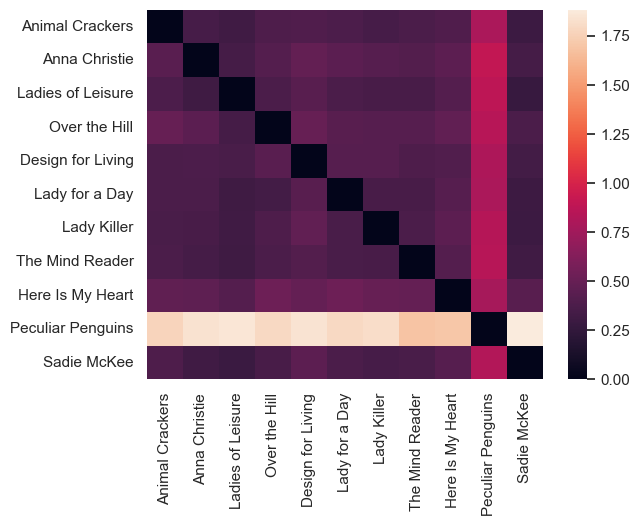

In [194]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()


To reveal more patterns, let's do a multidimensional scaling of the matrix.

In [195]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids):
    ax.annotate(txt, (x[i],y[i]))

/Users/apple/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


A co-respondent's course and The Chain Gang are away from the others - any guesses why?

We may just want to focus on the distrbution of stopwords or non-stopwords. Let's do the analysis again first for stopwords and then for non-stopwords.

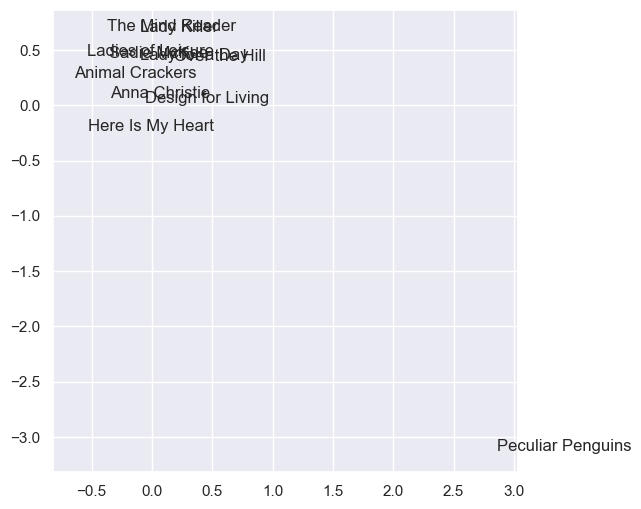

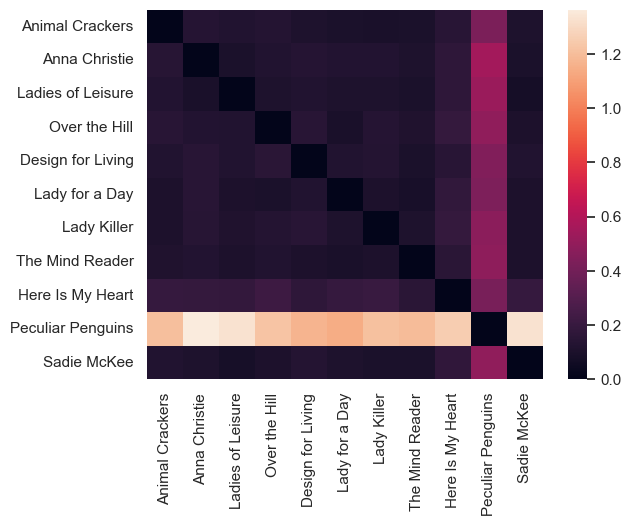

In [196]:
L = []
for p in corpora_s:
    l = []
    for q in corpora_s:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

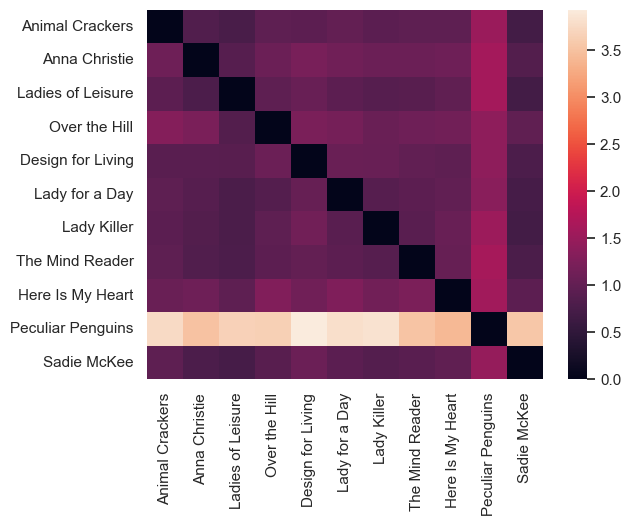

In [197]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

For the KS distance:

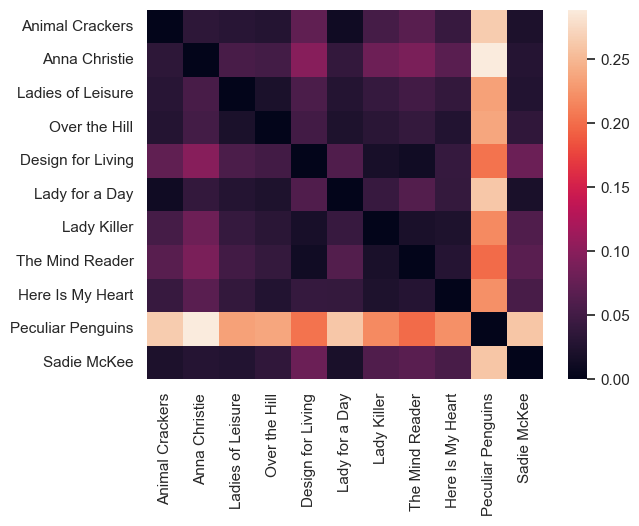

In [198]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KS'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

And finally for the Wasserstein or "earth mover's" Distance.

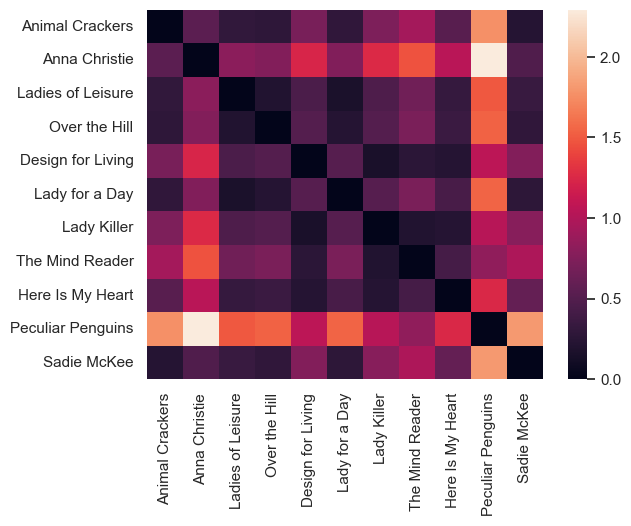

In [199]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Wasserstein'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

You can see that decade X is highly divergent and this makes reading the plot somewhat difficult. Let's fix this by taking the log of each cell, which will reduce the distance of decode X from other texts as an outlier.

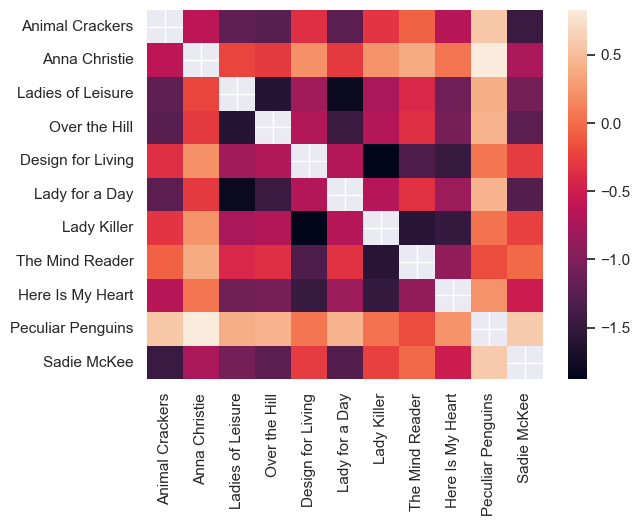

In [200]:
ax = sns.heatmap(div.apply(np.log).replace([np.inf, -np.inf], np.nan))
plt.show()

We only tried 11 movies, and from the same time period, so our signals might not be too interesting. What about different time periods?

An interesting experiment to maybe get some clearer signals: documents by decade in the Davies Corpus Of Historial American English (COHA) and see if we can detect patterns between them.

If we want to rerun this on a new data set of our own composition, we can be a bit more efficient with our coding. Let's use the Shakespeare texts from last week as example. Here we again make use of our convenient `lucem_illud` functions, namely `loadTextDirectory`, which is found in [loaders.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/loaders.py).

In [201]:
def loadTextDirectory(targetDir, encoding = 'utf-8'):
    text = []
    fileName = []

    for file in (file for file in os.scandir(targetDir) if file.is_file() and not file.name.startswith('.')):
        with open(file.path, encoding = encoding) as f:
            text.append(f.read())
        fileName.append(file.name)
    return pandas.DataFrame({'text' : text}, index = fileName)

In [202]:
shakespeare_df = lucem_illud.loadTextDirectory('../data/Shakespeare')

Now we stem and remove stopwords

In [203]:
shakespeare_df['tokenized_text'] = shakespeare_df['text'].apply(lambda x: word_tokenize(x))
shakespeare_df['normalized_tokens'] = shakespeare_df['tokenized_text'].apply(lambda x: normalizeTokens(x))

/Users/apple/anaconda3/lib/python3.11/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Create the corpus file and generate the heatmap:

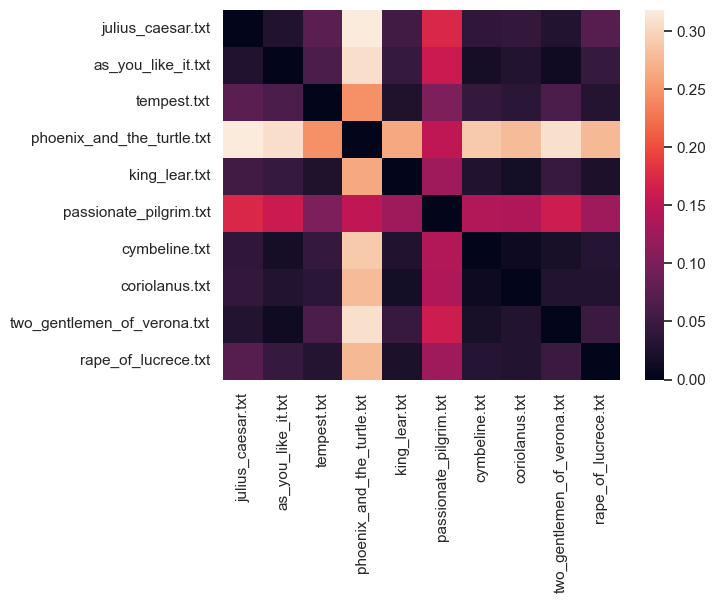

In [204]:
measure = 'KS' #"KL", "Chi2", "KS", "Wasserstein"
num_of_texts = 10 #The bigger this number the slower it will run, you can also try selecting your own plays
fileids_sp = list(shakespeare_df[:num_of_texts].index)
corpora_sp = list(shakespeare_df[:num_of_texts]['normalized_tokens'])
L = []
for p in corpora_sp:
    l = []
    for q in corpora_sp:
        l.append(Divergence(p,q, difference=measure))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids_sp, index = fileids_sp)
ax = sns.heatmap(div)
plt.show()

What are "The Passionate Pilgrim" and "The Phoenix and the Turtle"? Little known poems by Shakespeare that are unsurprisingly hard to classify, as they are so different from everything else he wrote.

## <font color="red">*Exercise 7*</font>

<font color="red">Construct cells immediately below this that calculate the KL and $\chi^2$ divergences, and the KS and Wasserstein distances between four separate corpora, plot these with heatmaps, and then array them in two dimensions with multidimensional scaling as above. What does this reveal about relations between the corpora? Which analysis (and divergence or distribution) distinguishes the authors or documents better?

**Stretch**: Calculate the [Jensen-Shannon Divergence](https://en.wikipedia.org/wiki/Jensen–Shannon_divergence) between your four corpora. What is the relationship between the KL and JS divergences?</font>

In [280]:
# df1: "Women in Work" Group dataset (df: "Women in Academia" Group dataset)
file_path = "wiw.xlsx"
df1 = pd.read_excel(file_path)
df1 = df1.rename(columns={'字段1': 'text', '字段2': 'like',
               '字段3': 'collect', '字段4': 'repost'})
df1 = df1[df1['讨论'] != '讨论']
df1.head()

讨论  \
1  精华\n\n\n                    \n                ...   
2                                           关于恶意攻击组员   
3                                     有没有对心理文化感兴趣的姐妹   
4                避雷YY评级（Ratingdog)，老板用女intern照片引流做卖点   
5                             大家对女性小玩具感兴趣么，想做相关方面的创业   

                                            讨论链接      作者   回应         最后回应  \
1  https://www.douban.com/group/topic/201992114/  小脆梨甜瓜儿   54   2022-10-14   
2  https://www.douban.com/group/topic/260090171/   Яανeη  NaN   2022-02-15   
3  https://www.douban.com/group/topic/289601664/      线条    3  01-15 19:42   
4  https://www.douban.com/group/topic/292159631/    momo    2  01-12 18:15   
5  https://www.douban.com/group/topic/279547552/      智昏   18  01-12 18:14   

                  发布时间                                               text  \
1  2020-11-22 09:02:17  不知道群里有没有姐妹求职方向是咨询～本人目前本科毕业，gap申请研究生中。mock数量在30...   
2  2022-02-15 06:17:26  任何恶意攻击组员出口不逊的评论都会删帖并且永拒处理。可以不同意对方的观点，不可以恶意攻击。提...   
3  2023-06-04 09:16:46  本人心理从业十几年，个案为主现在想转个型做点和心理文化有关的东西，像此念那种，但是是草根版的...   
4  2023-07-23 17:01:04  代发组外投稿避雷YY评级（Ratingdog），创始人宣称自己是“女性友好雇主”，但是却用女...   
5  2022-12-03 11:51:12  单身女性经济应该也算是一种新趋势吧，周围的女生们普遍对婚育更保守了，但对sex的态度其实是越...   

   like  collect  repost  
1  30.0     80.0     4.0  
2   1.0      NaN     NaN  
3   2.0      1.0     2.0  
4   3.0      NaN     NaN  
5  15.0     24.0     1.0

In [263]:
# df2: "Women in Finance" Group dataset
file_path = "wif.xlsx"
df2 = pd.read_excel(file_path)
df2 = df2.rename(columns={'字段1': 'text', '字段2': 'like',
                          '字段3': 'collect', '字段4': 'repost'})
df2 = df2[df2['讨论'] != '讨论']
df2.head()

讨论  \
1                                      2022年7月招聘信息专楼   
2  精华\n\n\n                    \n                ...   
3  精华\n\n\n                    \n                ...   
4  精华\n\n\n                    \n                ...   
5                                        申请被拒的原因（必看）   

                                            讨论链接     作者  回应        最后回应  \
1  https://www.douban.com/group/topic/269956499/     笛辣  29  2023-03-07   
2  https://www.douban.com/group/topic/227769504/  米奇妙妙屋  35  2022-10-12   
3  https://www.douban.com/group/topic/264007401/     笛辣  53  2022-05-20   
4  https://www.douban.com/group/topic/227820191/     笛辣  11  2022-05-12   
5  https://www.douban.com/group/topic/245600351/    君惜凉  14  2022-04-11   

                  发布时间                                               text  \
1  2022-07-01 10:03:48  因招聘信息有时效性，请大家把2022年7月发布的招聘相关信息在本帖下留言，谢谢大家！谢谢姐妹...   
2  2021-05-26 14:36:50  感觉组里最近重复的帖子有点多，稍微整理了一些常看到的，如果有lz不想出现在这里可以豆油我删掉...   
3  2022-04-06 07:47:02  最新更新：我们小组已经转为公开小组，入组方式换回以前的申请制，详情：Women in Fin...   
4  2021-05-26 20:26:01  希望大家在发贴前先在组内和网上进行搜索，不做伸手党，帖中提出明确、具体的问题，并介绍相关的背...   
5  2021-09-07 18:31:07  本组的原则是girls help girls，为了打造高质量小组，争取做豆瓣985🤣，申请有...   

    like  collect  repost  
1   22.0     63.0     4.0  
2  157.0   1389.0    82.0  
3   38.0      6.0     1.0  
4   17.0     12.0     2.0  
5   49.0     11.0     4.0

In [264]:
# df3: "Women in Law" Group dataset (df: "Women in Academia" Group dataset)
file_path = "wil.xlsx"
df3 = pd.read_excel(file_path)
df3 = df3.rename(columns={'字段1': 'text', '字段2': 'like',
                          '字段3': 'collect', '字段4': 'repost'})
df3 = df3[df3['讨论'] != '讨论']
df3.head()

讨论  \
1                                Women In Law 拉群贴汇总楼   
2                                               组内交流   
3                        🙇🏻‍♀️内推需求专楼：需要被内推的朋友来呀，注...   
4                                 💻渴求人才专楼：招聘的姐妹们看这里～   
5  精华\n\n\n                    \n                ...   

                                            讨论链接      作者   回应        最后回应  \
1  https://www.douban.com/group/topic/263486567/  Vivian  268  2023-12-29   
2  https://www.douban.com/group/topic/260678880/  Vivian  163  2023-12-28   
3  https://www.douban.com/group/topic/198426810/  Vivian  466  2023-11-06   
4  https://www.douban.com/group/topic/198427030/  Vivian  204  2023-11-02   
5  https://www.douban.com/group/topic/212338466/  Vivian   32  2022-10-17   

                  发布时间                                               text  \
1  2022-03-30 05:55:30  最近组内有很多【拉群贴】，主要是准备考试/寻找不同区域律师实践交流/资料共享这些类型。非常理...   
2  2022-02-22 05:00:28  之前的帖子被豆瓣删掉了。想要加入组内交流的姐妹们，欢迎私信我。我一一拉你们。私信我你的wx号...   
3  2020-10-24 01:04:25  这是小组的内推专楼。大家不要单独开贴啦。为了保护大家的隐私，请需要被内推的朋友在这里留言。有...   
4  2020-10-24 01:08:14  这是小组的招聘专楼。大家就不用单独开贴啦。😆为了保护大家的隐私，招聘岗位的都可以在这里留言。...   
5  2021-02-22 12:10:53  本期活动我们邀请五位有申请澳洲/香港法学院经验的朋友来分享她们的经历和经验。 🙌🙌🙌在本次分...   

    like  collect  repost  
1   22.0    113.0     4.0  
2   15.0      3.0     NaN  
3  218.0   1124.0    38.0  
4   64.0    781.0    27.0  
5   40.0    108.0     8.0

In [268]:
df['tokenized_text'] = df['text'].apply(
    lambda x: tokenize_cn(x))
df['normalized_tokens'] = df['tokenized_text'].apply(
    lambda x: normalize_cn_Tokens(x))

/var/folders/lf/x2qjgwcx40s09kw6tkvpy7200000gn/T/ipykernel_3393/1180142423.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokenized_text'] = df['text'].apply(
/var/folders/lf/x2qjgwcx40s09kw6tkvpy7200000gn/T/ipykernel_3393/1180142423.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['normalized_tokens'] = df['tokenized_text'].apply(


In [269]:
df['normalized_tokens']

1       [猴面包树, 组员, 倡议, 小组, 建立, 官方, slack, 交流, 群, 营造, 更...
2       [本帖, 问卷调查, 招募, 研究, 对象, 贴, 姐妹, 问卷调查, 帮忙, 填写, 招募...
3       [前, 情, 意见, 征集, 贴, https, www, douban, group, t...
4       [论坛, 第二期, 分享, 会, 说, phd, 人生, 路径, 文字, 稿, 音频, 分享...
5       [更新, 管理员, 实在, 能力, 追踪, 申请, 相关, 帖子, 相关, 帖子, 想要, ...
                              ...                        
5565    [这位, 前辈, 人, 好, 成果, 很多, 采访, 内容, 不少, 领域, specifi...
5566    [组, 人才济济, 更好, 整合, 利用, 资源, AMA, 帖子, 集合, 交流学习, P...
5567    [题, 美国, 文理学院, 理科, 教职, 申请, 工作, 日常, 工作, 环境, 晋升, ...
5569    [组, 人才济济, 更好, 整合, 利用, 资源, AMA, 帖子, 集合, 交流学习, P...
5570    [题, 美国, 文理学院, 理科, 教职, 申请, 工作, 日常, 工作, 环境, 晋升, ...
Name: normalized_tokens, Length: 5254, dtype: object

In [270]:
df1['tokenized_text'] = df1['text'].apply(
    lambda x: tokenize_cn(x))
df1['normalized_tokens'] = df1['tokenized_text'].apply(
    lambda x: normalize_cn_Tokens(x))

df2['tokenized_text'] = df2['text'].apply(
    lambda x: tokenize_cn(x))
df2['normalized_tokens'] = df2['tokenized_text'].apply(
    lambda x: normalize_cn_Tokens(x))

df3['tokenized_text'] = df3['text'].apply(
    lambda x: tokenize_cn(x))
df3['normalized_tokens'] = df3['tokenized_text'].apply(
    lambda x: normalize_cn_Tokens(x))

In [271]:
all_tokens = [token for sublist in df['normalized_tokens']
              if isinstance(sublist, list) for token in sublist]

all_tokens1 = [token for sublist in df1['normalized_tokens']
              if isinstance(sublist, list) for token in sublist]

all_tokens2 = [token for sublist in df2['normalized_tokens']
              if isinstance(sublist, list) for token in sublist]

all_tokens3 = [token for sublist in df3['normalized_tokens']
              if isinstance(sublist, list) for token in sublist]

dfWords = set(all_tokens)
df1Words = set(all_tokens1)
df2Words = set(all_tokens2)
df3Words = set(all_tokens3)

In [274]:
# check overlapping words in "women in academia" and "women in work"
overlapWords01 = dfWords & df1Words

overlapWordsDict01 = {word: index for index, word in enumerate(overlapWords01)}
overlapWordsDict01['phd']

2842

In [281]:
df1['tokenized_text'] = df1['text'].apply(
    lambda x: tokenize_cn(x))
df1['normalized_tokens'] = df1['tokenized_text'].apply(
    lambda x: normalize_cn_Tokens(x))

In [287]:
df1 = df1[df1['normalized_tokens'].apply(lambda x: isinstance(x, list))]

In [288]:
dfProbArray = makeProbsArray(df['normalized_tokens'], overlapWordsDict01)
df1ProbArray = makeProbsArray(
    df1['normalized_tokens'], overlapWordsDict01)

df_df1Divergence = scipy.stats.entropy(dfProbArray, df1ProbArray)
print(df_df1Divergence)
df1_dfDivergence = scipy.stats.entropy(df1ProbArray, dfProbArray)
print(df1_dfDivergence)

0.5296149636497913
0.5649139295304049


In [290]:
df_df1Divergence_ew = scipy.special.kl_div(dfProbArray, df1ProbArray)
kl_df01 = pandas.DataFrame(list(overlapWordsDict01.keys()), columns=[
                         'word'], index=list(overlapWordsDict01.values()))
kl_df01 = kl_df01.sort_index()
kl_df01['elementwise divergence'] = df_df1Divergence_ew
kl_df01[:10]
kl_df01.sort_values(by='elementwise divergence', ascending=False)[:10]

word  elementwise divergence
7999   申请                0.019062
7387   导师                0.015076
6714   博士                0.012948
2842  phd                0.010574
5582   学术                0.009882
7571   老师                0.009476
5809   论文                0.008800
4872   研究                0.008699
104    读博                0.006797
1685   教授                0.006534

In [293]:
corpora = []
for index, row in df.iterrows():
    if len(corpora) > 10:
        break
    corpora.append(row['tokenized_text'])

In [298]:
stoplist # Chinese stoplist loaded before

['里',
 '是',
 '有',
 '想',
 '很',
 '出',
 '做',
 '不',
 '日',
 '月',
 '年',
 '的',
 '太',
 '被',
 '在',
 '且',
 '和',
 '还',
 '其',
 '把',
 '将',
 '一',
 '了',
 '对',
 '我',
 '也',
 '应',
 '这',
 '那',
 '-',
 '－－',
 '_',
 '—',
 '—',
 '?',
 '？',
 '！',
 '!',
 '.',
 '·',
 '。',
 '，',
 ',',
 "'",
 '`',
 ';',
 '；',
 '、',
 '/',
 '\\',
 ']',
 '[',
 '{',
 '}',
 '(',
 ')',
 '（',
 '）',
 '-',
 '+',
 '=',
 '“',
 '”',
 "'",
 "'",
 '《',
 '》',
 '<',
 '>',
 'able',
 'about',
 'above',
 'according',
 'accordingly',
 'across',
 'actually',
 'after',
 'afterwards',
 'again',
 'against',
 "ain't",
 'all',
 'allow',
 'allows',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'an',
 'and',
 'another',
 'any',
 'anybody',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anyways',
 'anywhere',
 'apart',
 'appear',
 'appreciate',
 'appropriate',
 'are',
 "aren't",
 'around',
 'as',
 "a's",
 'aside',
 'ask',
 'asking',
 'associated',
 'at',
 'available',
 'away',
 'awfully',
 'be',
 '

In [301]:
corpora

[['由',
  '猴面包树',
  '组员',
  '倡议',
  '，',
  '我们',
  '小组',
  '建立',
  '官方',
  'slack',
  '交流',
  '群',
  '啦',
  '！',
  '为了',
  '营造',
  '一个',
  '更',
  '友好',
  '安全',
  '的',
  '交流',
  '氛围',
  '，',
  '目前',
  '加入',
  '小组',
  'slack',
  '群',
  'by',
  ' ',
  'invitation',
  ' ',
  'only',
  '，',
  '进群',
  '方式',
  '详见',
  '后文',
  '。',
  'slack',
  '目前',
  '没有',
  '地区',
  '限制',
  '，',
  '有分',
  'channel',
  '、',
  '自定义',
  'emoji',
  '、',
  '智能',
  'bot',
  '等',
  '丰富',
  '的',
  '功能',
  '，',
  'slack',
  '新手',
  '可以',
  '看',
  '这个',
  '官方',
  'slack',
  '官方',
  '指南',
  '目前',
  '设置',
  '的',
  'channel',
  '包括',
  '：',
  '#',
  'general',
  ' ',
  '主',
  'channel',
  '#',
  'random',
  ' ',
  '日常',
  '闲聊',
  '划水',
  '，',
  '逃避',
  '工作',
  '虽',
  '可耻',
  '但',
  '却',
  '快乐',
  '！',
  '#',
  'social',
  '-',
  'sciences',
  ' ',
  '社会科学',
  '姐妹',
  '聚集地',
  '#',
  'humanities',
  ' ',
  '人文',
  '艺术',
  '姐妹',
  '聚集地',
  '#',
  'engineering',
  ' ',
  '工程',
  '姐妹',
  '聚集地',
  '#',
  'natural',
  '-',
  's

In [302]:
# seperate the corpora into stopwords and non-stopwords
corpora_s = []
corpora_nons = []
for corpus in corpora:
    s = []
    nons = []
    
    for word in corpus:
        if word in stoplist:
            s.append(word)
        else:
            nons.append(word)
    corpora_s.append(s)
    corpora_nons.append(nons)

In [307]:
field_ids = list(df['发布时间'])[0:11]

In [308]:
field_ids

['2020-10-09 08:25:49',
 '2020-10-14 12:38:45',
 '2020-10-10 22:01:03',
 '2020-11-02 04:35:37',
 '2020-12-09 03:43:55',
 '2020-11-28 08:53:06',
 '2020-09-23 10:49:44',
 '2020-11-14 20:42:09',
 '2020-09-25 07:33:29',
 '2021-03-29 11:48:54',
 '2024-01-11 15:15:08']

In [311]:
corpora

[['由',
  '猴面包树',
  '组员',
  '倡议',
  '，',
  '我们',
  '小组',
  '建立',
  '官方',
  'slack',
  '交流',
  '群',
  '啦',
  '！',
  '为了',
  '营造',
  '一个',
  '更',
  '友好',
  '安全',
  '的',
  '交流',
  '氛围',
  '，',
  '目前',
  '加入',
  '小组',
  'slack',
  '群',
  'by',
  ' ',
  'invitation',
  ' ',
  'only',
  '，',
  '进群',
  '方式',
  '详见',
  '后文',
  '。',
  'slack',
  '目前',
  '没有',
  '地区',
  '限制',
  '，',
  '有分',
  'channel',
  '、',
  '自定义',
  'emoji',
  '、',
  '智能',
  'bot',
  '等',
  '丰富',
  '的',
  '功能',
  '，',
  'slack',
  '新手',
  '可以',
  '看',
  '这个',
  '官方',
  'slack',
  '官方',
  '指南',
  '目前',
  '设置',
  '的',
  'channel',
  '包括',
  '：',
  '#',
  'general',
  ' ',
  '主',
  'channel',
  '#',
  'random',
  ' ',
  '日常',
  '闲聊',
  '划水',
  '，',
  '逃避',
  '工作',
  '虽',
  '可耻',
  '但',
  '却',
  '快乐',
  '！',
  '#',
  'social',
  '-',
  'sciences',
  ' ',
  '社会科学',
  '姐妹',
  '聚集地',
  '#',
  'humanities',
  ' ',
  '人文',
  '艺术',
  '姐妹',
  '聚集地',
  '#',
  'engineering',
  ' ',
  '工程',
  '姐妹',
  '聚集地',
  '#',
  'natural',
  '-',
  's

<Figure size 640x480 with 0 Axes>

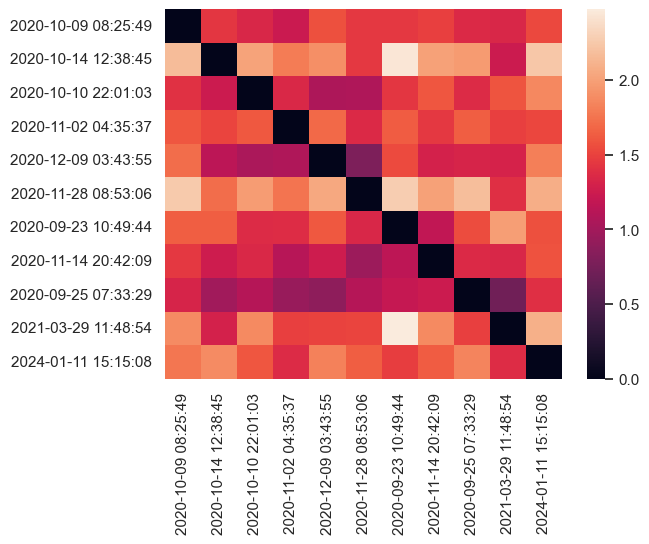

In [313]:
# illustrate the convergence of the top 11 posts in "women in academia"
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p, q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns=field_ids, index=field_ids)
ax = sns.heatmap(div)
plt.show()

/Users/apple/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


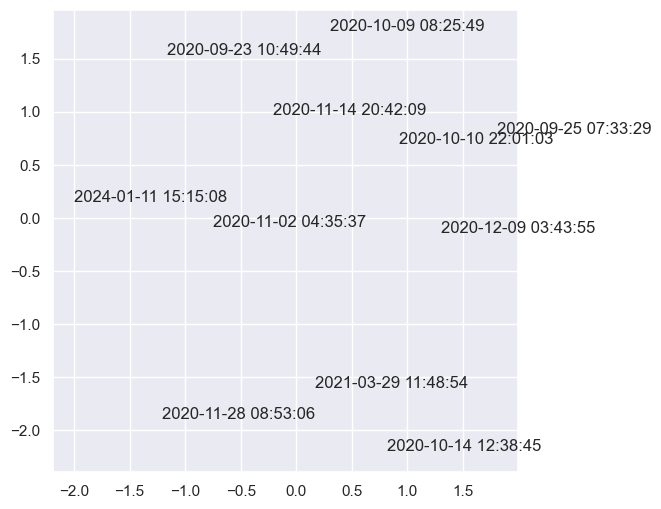

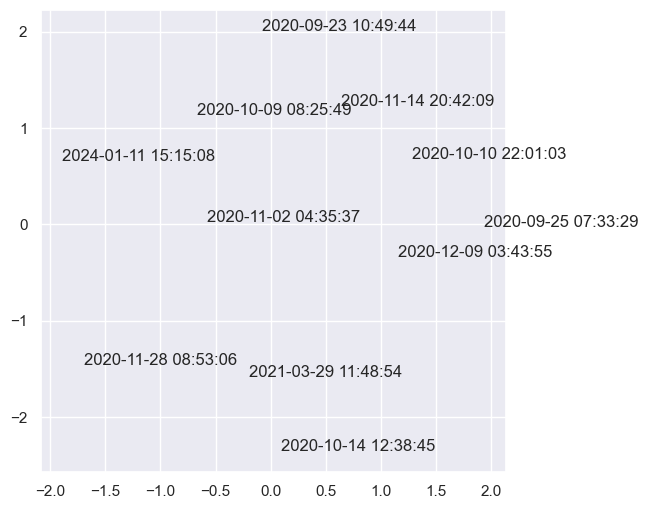

In [317]:
# multi-dimensional scaling
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:, 0]
y = pos[:, 1]
fig, ax = plt.subplots(figsize=(6, 6))
plt.plot(x, y, ' ')
for i, txt in enumerate(field_ids):
    ax.annotate(txt, (x[i], y[i]))
plt.show()

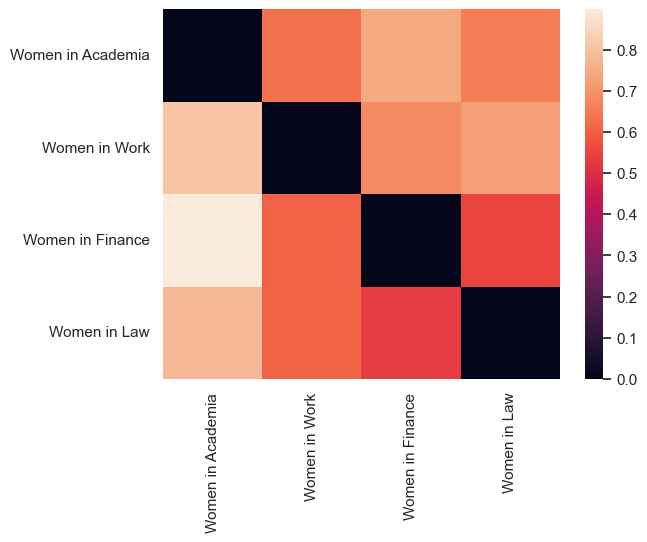

In [321]:
# illustrate the convergence of the 4 groups
group_corpora = [all_tokens, all_tokens1, all_tokens2, all_tokens3]
group_name = ["Women in Academia", "Women in Work", "Women in Finance", "Women in Law"]
L = []
for p in group_corpora:
    l = []
    for q in group_corpora:
        l.append(Divergence(p, q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns=group_name, index=group_name)
ax = sns.heatmap(div)
plt.show()